**Step 1: Import packages**

In [1]:
# Import libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import kerastuner as kt
import IPython

# sklearn libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# sklearn libraries for models
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner import Hyperband

# sklearn libraries for evaluation
from sklearn import metrics

**Step 2: Define working directories**

In [ ]:
os.chdir('C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project')

**Step 3: Define classes**

In [2]:
# Clear the training outputs at the end of every step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        '''Clear the training outputs at the end of every step for the Keras Tuner'''
        IPython.display.clear_output(wait = True)

**Step 4: Define functions**

In [3]:
def reduce(X, n):
    '''PCA dimensionality reduction for X array and n principal components'''
    ss = StandardScaler()
    XS = ss.fit_transform(X)
    pca = PCA(n_components = n) 
    X_reduced = pca.fit_transform(XS)
    return X_reduced

In [4]:
def data_split(X, y, test_p):
    '''Split train and test data for X,y data arrays with test_p percentage of observations in the test data and 
    mini_s number of observations in the mini_train set.'''
    # Split into train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=test_p, random_state=1, stratify=y)

    # Split test data into development data and training into mini train set for computation time
    dev_data, dev_labels = test_data[:int(test_data.shape[0]*0.5)], test_labels[:int(test_data.shape[0]*0.5)]
    test_data_sub, test_labels_sub = test_data[int(test_data.shape[0]*0.5):], test_labels[int(test_data.shape[0]*0.5):]
    print('Train data shape:', train_data.shape)
    print('Dev data shape:', dev_data.shape)
    print('Test data shape:', test_data.shape)
    
    return train_data, train_labels, test_data_sub, test_labels_sub, dev_data, dev_labels

In [5]:
def log_reg(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        error = (dev_Y != clf_pred).sum()/len(clf_pred)
        acc = round(1-error,3)
        LR.append(round(acc,3))

    return LR, c_values

In [6]:
def LR_accuracy_c(train_X, train_Y, dev_X, dev_Y):
    '''Calls logistic regression function and returns highest accuracy for specific value of C.'''
    accuracy_list = log_reg(train_X, train_Y, dev_X, dev_Y)[0]
    accuracy = [y for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    accuracy_index = [x for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    C = log_reg(train_X, train_Y, dev_X, dev_Y)[1][accuracy_index[0]]
    
    return accuracy[0], C

In [7]:
def log_reg_l1(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto', penalty = 'l1')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        LR.append(round(metrics.f1_score(dev_Y, clf_pred, average='weighted'),3))

    return LR, c_values

In [8]:
def PCA_visualization(pca_vals, title, colors):
    x = [item[0] for item in pca_vals] 
    y = [item[1] for item in pca_vals] 

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.scatter(x, y, c=colors, s = 5)
    ax.grid()

In [9]:
def PCA_k_optimize(train_X, train_Y, dev_X, dev_Y, k_list):
    accuracies = []
    c_vals = []
    # Subset pixel data
    train_pixel = train_X[:, :150529]
    dev_pixel = dev_X[:, :150529]
    train_nopixel = train_X[:, 150529:]
    dev_nopixel = dev_X[:, 150529:]
    for k in k_list:
        #Scale and reduce only pixel data
        ss = StandardScaler()
        train_pixel_s = ss.fit_transform(train_pixel)
        dev_pixel_s = ss.transform(dev_pixel)
        pca = PCA(n_components = k) 
        train_pixel_reduced = pca.fit_transform(train_pixel_s)
        dev_pixel_reduced = pca.transform(dev_pixel_s)
        #Concatenate reduced pixel data back with non pixel data
        train_X_new = np.concatenate((train_nopixel, train_pixel_reduced), axis=1)
        dev_X_new = np.concatenate((dev_nopixel, dev_pixel_reduced), axis=1)
        #Obtain accuracy and optimized c value
        results = LR_accuracy_c(train_X_new, train_Y, dev_X_new, dev_Y)
        accuracies.append(results[0])
        c_vals.append(results[1])
    return accuracies, c_vals

In [10]:
def model_builder(hp):
    '''Build a single layer dense neural network using Keras Tuner'''
    model = keras.Sequential()
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
    return model

In [11]:
def build_model(nodes, dropout_rate, lr):
    '''Build layers of a neural net'''
    
    # Begins the linear arrangment of layers
    model = tf.keras.models.Sequential([

    # First layer 
    # This is a dense layer. Nodes are fully connected.
    # Nodes is the number of nodes in the layer. This will be specified when calling the function.
    tf.keras.layers.Dense(nodes, activation='relu'),

    # Second layer
    # Uses dropout regularization by dropping a certain percentage before next layer
    # This makes it so that some of the nodes in a given layer don’t pass on their information to the next layer. 
    # This helps with computation time (less parameters) and with overfitting.
    # Each node in the second  layer has a probability equal to the specified dropout rate of being dropped from the computation of the activations of the next layer. 
    tf.keras.layers.Dropout(dropout_rate),
    
    # Third layer
    # This is the output layer. It returns a logits array of length 2 (because we have 2 classes - logo or not logo)
    # Each node contains a probability that indicates the current image belongs to one of the 2 classes
    # It uses the activation function Softmax which is the equivalent of the Sigmoid function for multiclass logits
    tf.keras.layers.Dense(2, activation='softmax')])
    
    # Compile the model using the Adam optimizer
    # The learning rate will be specified when the function is called
    model.compile(keras.optimizers.Adam(learning_rate = lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [12]:
# Fit the neural net model
# Specify the number of epochs
def fit_model(model, data, labels, epoch_num):
    history = model.fit(data, labels, epochs = epoch_num)
    return history

In [13]:
# Evaluate the neural net model
def evaluate_model(model, data, labels):
    test_loss, test_acc = model.evaluate(data, labels)
    return test_acc

**Step 5: Read data**

5.1 Load and combine pixel data files into dataframe

In [14]:
# Load npz files to combine and print content files
data_1 = np.load('et_w207_project_npz_files_5000_tmp_tmp5ocrhjnn.npz')
data_1.close

data_2 = np.load('et_w207_project_npz_files_5000_tmp_tmp092sag67.npz')
data_2.close

data_3 = np.load('et_w207_project_npz_files_5000_tmp_tmpf31_pn8p.npz')
data_3.close

data_4 = np.load('et_w207_project_npz_files_5000_tmp_tmpq5b2g4n2.npz')
data_4.close

print(data_1.files)

['arr_0', 'arr_1']


In [15]:
# Show file arr_0 example
data_1['arr_0'][:5]

array(['ozbpir-9ey6js-ggdqwo', '378ykanq', 'p366md-big834-7o23k6',
       '3zruwvl2', 'q18iae-3vnh74-79npmy'], dtype='<U20')

In [16]:
# Show file arr_1 example
data_1['arr_1'][:5]

array([[-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ],
       [ -46.939003,  -74.779   , -118.68    , ...,  -57.939003,
         -84.779   , -118.68    ],
       [ 151.061   ,  138.22101 ,  131.32    , ...,  151.061   ,
         138.22101 ,  131.32    ],
       [  -3.939003,  -66.779   ,  -96.68    , ...,   -3.939003,
         -66.779   ,  -96.68    ],
       [-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ]], dtype=float32)

In [17]:
# Get number of observations in each file
print(data_1['arr_0'].shape)
print(data_2['arr_0'].shape)
print(data_3['arr_0'].shape)
print(data_4['arr_0'].shape)

(878,)
(893,)
(638,)
(1353,)


In [18]:
# Concatenate data from all files
data_key = np.concatenate((data_1['arr_0'], data_2['arr_0'], data_3['arr_0'], data_4['arr_0']))

data_pixel = np.concatenate((data_1['arr_1'], data_2['arr_1'], data_3['arr_1'], data_4['arr_1']))
print(data_pixel.shape)

(3762, 150528)


In [19]:
# Create key value pairs with attachment key and pixel array
# Standardize pixel values between 0 and 1 by dividing by 255
# Store pixel data as dataframe
data_dict = {}
for i in range(data_key.shape[0]):
    data_dict[data_key[i]] = [data_pixel[i]/255]

df_pixel = pd.DataFrame(data=data_dict)
df_pixel_t = df_pixel.transpose()
df_pixel_t.index.names = ['attachment_key']
df_pixel_t.columns = ['pixel_array']
df_pixel_t

pixel_array
attachment_key                                                         
ozbpir-9ey6js-ggdqwo  [-0.40760392, -0.45795685, -0.4850196, -0.4076...
378ykanq              [-0.18407452, -0.29325098, -0.46541175, -0.097...
p366md-big834-7o23k6  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...
3zruwvl2              [-0.015447071, -0.26187843, -0.37913725, -0.01...
q18iae-3vnh74-79npmy  [-0.40760392, -0.45795685, -0.4850196, -0.4076...
...                                                                 ...
pktyig-481wyg-6gyulf  [-0.3605451, -0.41089803, -0.38305882, -0.3644...
zu7y3rha              [-0.007603933, -0.05795686, -0.08501961, -0.00...
pxcwxf-8tnpyg-8vhb9r  [0.3022, 0.18125883, 0.12674509, 0.31004313, 0...
p4hakf-fsskmw-1224up  [-0.40368235, -0.45403528, -0.48109803, -0.387...
ptuhsk-22124o-f0sxoc  [0.43945488, 0.39302352, 0.3502745, 0.44729802...

[3759 rows x 1 columns]

5.2 Load metadata file

In [20]:
# Load excel data
df = pd.read_csv('school_project_data_set-new.csv')
df.head()

attachment_key   size_mb  height   width    h_to_w  \
0       001lq61k  0.122520   514.0   720.0  0.713889   
1       002dlirq  3.256944  4072.0  3868.0  1.052741   
2       003qefgm  0.002522    80.0   200.0  0.400000   
3       0083okjl  0.116802   600.0   600.0  1.000000   
4       00a957mh  0.140714   816.0  2382.0  0.342569   

                                filename  logo  
0       campus ministry on the beach.jpg     0  
1        BIG ALS FISH FLASH UV VP PL.jpg     0  
2                 netix_email_studio.png     1  
3                       productshot2.jpg     0  
4  divine_medical_billing_inc_master.png     1

5.3 Combine pixel and metadata features in a pandas dataframe

In [21]:
# Merge dataframes by attachment key
combined_df = df.merge(df_pixel_t, on='attachment_key')
combined_df

attachment_key   size_mb  height   width    h_to_w  \
0          00xjny6u  0.011849   520.0   506.0  1.027668   
1          04o31jop  0.012610   269.0   396.0  0.679293   
2          0840h7ox  0.399114   518.0   920.0  0.563044   
3          0awudx2h  0.011226   200.0   200.0  1.000000   
4          0bb8y85h  0.263813   885.0   800.0  1.106250   
...             ...       ...     ...     ...       ...   
3750       zu7y3rha  0.147371   498.0   702.0  0.709402   
3751       zuanbsqe  0.580392   206.0   415.0  0.496386   
3752       zw9234v4  2.021135  1645.0  1450.0  1.134483   
3753       zxfqbfj1  0.012057    36.0   345.0  0.104348   
3754       zzgkjqna  0.027983    56.0   350.0  0.160000   

                                               filename  logo  \
0                          Esterdale Theatre - Logo.png     1   
1                                         BLUE_LOGO.png     1   
2                                          ZEN_LB-5.jpg     0   
3                               article central 200.jpg     1   
4                             1116-100_WGTank_white.jpg     0   
...                                                 ...   ...   
3750                                     journalism.jpg     0   
3751  2013 05 26_techstars_id_final_bug solo graysca...     1   
3752                  SPIN N GLO SILVER WING GPK MY.jpg     0   
3753                    cornerstone web logo medium.png     1   
3754                      fieldcontrolslogohorz web.jpg     1   

                                            pixel_array  
0     [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
1     [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
2     [0.106121555, 0.05576863, 0.052235294, 0.09043...  
3     [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
4     [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
...                                                 ...  
3750  [-0.007603933, -0.05795686, -0.08501961, -0.00...  
3751  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
3752  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  
3753  [-0.40760392, -0.45795685, -0.4850196, -0.4076...  
3754  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...  

[3755 rows x 8 columns]

5.4 Visualizations from Pandas profile

In [22]:
# replace blank cells with NaN 
combined_df.replace('', np.nan, inplace=True)

# select features for summary stats
profile = pandas_profiling.ProfileReport(combined_df[['size_mb', 'height', 'width', 'h_to_w', 'filename', 'logo']]) 
profile.to_notebook_iframe()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


From the profile above, we can see that heights, width and h_to_w each has 1 missing data. We need to remove them in the data processing.

**Step 6: Data preprocessing**

6.1 Remove null values

In [23]:
# Remove rows with null values
combined_df = combined_df[combined_df.height.notnull()]
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attachment_key  3754 non-null   object 
 1   size_mb         3754 non-null   float64
 2   height          3754 non-null   float64
 3   width           3754 non-null   float64
 4   h_to_w          3754 non-null   float64
 5   filename        3754 non-null   object 
 6   logo            3754 non-null   int64  
 7   pixel_array     3754 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 264.0+ KB


6.2 Create file type dummy variables from file name

In [24]:
# Find file types from filename
file_types = []
for item in combined_df['filename']:
    file_types.append(item[-3:].lower())

print(set(file_types))

{'0mm', 'jpe', 'peg', 'ack', '73e', 'png', 'lue', 'pig', 'hot', 'age', 'ite', 'jpg'}


In [25]:
# Create list of file types from filename to append to df
filetype_encoding = []
for item in combined_df['filename']:
    if item[-3:].lower() == 'jpg':
        filetype_encoding.append('jpg')
    elif item[-3:].lower() == 'png':
        filetype_encoding.append('png')
    else:
        filetype_encoding.append('other')

In [26]:
# Create df that includes column for file type
combined_df['filetype'] = filetype_encoding
combined_df = combined_df[['attachment_key', 'size_mb', 'height', 'width', 'h_to_w', 'filetype', 'pixel_array', 'filename','logo']]
combined_df.head()
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


attachment_key   size_mb  height  width    h_to_w filetype  \
0       00xjny6u  0.011849   520.0  506.0  1.027668      png   
1       04o31jop  0.012610   269.0  396.0  0.679293      png   
2       0840h7ox  0.399114   518.0  920.0  0.563044      jpg   
3       0awudx2h  0.011226   200.0  200.0  1.000000      jpg   
4       0bb8y85h  0.263813   885.0  800.0  1.106250      jpg   

                                         pixel_array  \
0  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
1  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
2  [0.106121555, 0.05576863, 0.052235294, 0.09043...   
3  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
4  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   

                       filename  logo  
0  Esterdale Theatre - Logo.png     1  
1                 BLUE_LOGO.png     1  
2                  ZEN_LB-5.jpg     0  
3       article central 200.jpg     1  
4     1116-100_WGTank_white.jpg     0

In [27]:
# Get dummies for file type
filetype_dummies = pd.get_dummies(combined_df.filetype)

# add to initial df
combined_df = pd.concat((combined_df, filetype_dummies), axis=1)

# print head of df
combined_df.head()

attachment_key   size_mb  height  width    h_to_w filetype  \
0       00xjny6u  0.011849   520.0  506.0  1.027668      png   
1       04o31jop  0.012610   269.0  396.0  0.679293      png   
2       0840h7ox  0.399114   518.0  920.0  0.563044      jpg   
3       0awudx2h  0.011226   200.0  200.0  1.000000      jpg   
4       0bb8y85h  0.263813   885.0  800.0  1.106250      jpg   

                                         pixel_array  \
0  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
1  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
2  [0.106121555, 0.05576863, 0.052235294, 0.09043...   
3  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   
4  [0.5923961, 0.54204315, 0.51498044, 0.5923961,...   

                       filename  logo  jpg  other  png  
0  Esterdale Theatre - Logo.png     1    0      0    1  
1                 BLUE_LOGO.png     1    0      0    1  
2                  ZEN_LB-5.jpg     0    1      0    0  
3       article central 200.jpg     1    1      0    0  
4     1116-100_WGTank_white.jpg     0    1      0    0

6.3 Scale metadata variables

In [28]:
# Scale continuous feature variables
combined_df['size_mb'] = preprocessing.scale(combined_df['size_mb'])
combined_df['h_to_w'] = preprocessing.scale(combined_df['h_to_w'])
combined_df['height'] = preprocessing.scale(combined_df['height'])
combined_df['width'] = preprocessing.scale(combined_df['width'])

6.4 Create X, y arrays

In [29]:
# Organize df to separate into feature arrays
combined_df = combined_df[['attachment_key', 'pixel_array', 'size_mb', 'h_to_w', 'jpg', 'png', 'other',
                                     'height', 'width', 'logo', 'filetype', 'filename']]
combined_df.head()

attachment_key                                        pixel_array   size_mb  \
0       00xjny6u  [0.5923961, 0.54204315, 0.51498044, 0.5923961,... -0.366308   
1       04o31jop  [0.5923961, 0.54204315, 0.51498044, 0.5923961,... -0.366187   
2       0840h7ox  [0.106121555, 0.05576863, 0.052235294, 0.09043... -0.304882   
3       0awudx2h  [0.5923961, 0.54204315, 0.51498044, 0.5923961,... -0.366407   
4       0bb8y85h  [0.5923961, 0.54204315, 0.51498044, 0.5923961,... -0.326343   

     h_to_w  jpg  png  other    height     width  logo filetype  \
0  0.638439    0    1      0 -0.712708 -0.888611     1      png   
1 -0.187892    0    1      0 -0.861519 -0.943446     1      png   
2 -0.463630    1    0      0 -0.713894 -0.682232     0      jpg   
3  0.572811    1    0      0 -0.902427 -1.041152     1      jpg   
4  0.824832    1    0      0 -0.496310 -0.742052     0      jpg   

                       filename  
0  Esterdale Theatre - Logo.png  
1                 BLUE_LOGO.png  
2                  ZEN_LB-5.jpg  
3       article central 200.jpg  
4     1116-100_WGTank_white.jpg

The following profile shows that logo has high correlation with jpg, png file type. The logo has low correlation with other file types. And now, there is no missing data. We have 3754 total observations now which is 1 less than the previous profile. And this proofs that we have removed the null columns correctly.

In [30]:
# replace blank cells with NaN 
combined_df.replace('', np.nan, inplace=True)

# select features for summary stats
profile = pandas_profiling.ProfileReport(combined_df[['size_mb', 'height', 'width', 'h_to_w', 'jpg', 'png', 'other', 'filename', 'filetype', 'logo']]) 
profile.to_notebook_iframe()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [31]:
# y array contains logo/not logo binary variable
y = np.array(combined_df.iloc[:, 9])

# X array contains pixel array only
pixel_X = np.array(combined_df['pixel_array'].tolist())
print(pixel_X.shape)


(3754, 150528)


In [32]:
# Reduce dimensionality of pixel array
pixel_reduced = reduce(pixel_X,2)

# Reduce dimensionality of non-pixel data
nopixel_X = np.array(combined_df.iloc[:, 2:9].values)
nopixel_reduced = reduce(nopixel_X,2)

# Reduce dimensionality of pixel and non-pixel data
combined_X = np.concatenate((nopixel_X, pixel_X), axis = 1)
combined_reduced = reduce(combined_X,2)

colors = ['r' if label == 0 else 'g' for label in y]

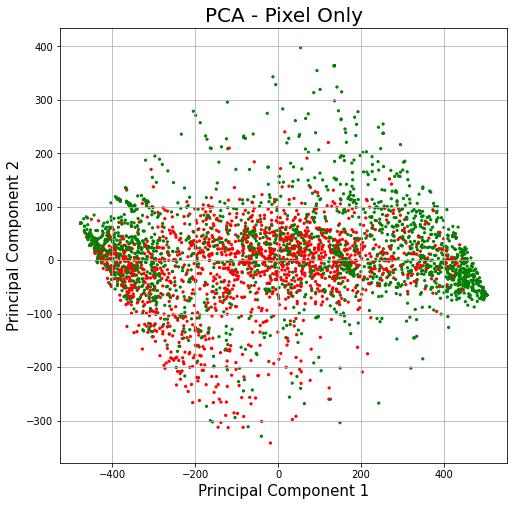

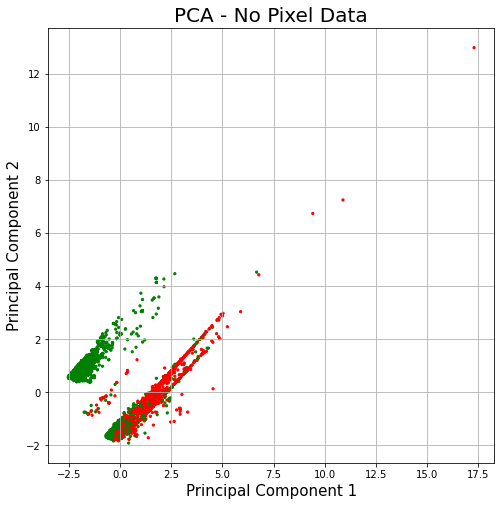

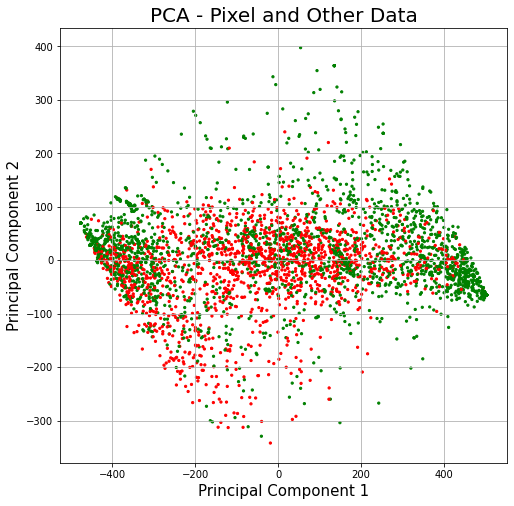

In [33]:
PCA_visualization(pixel_reduced,'PCA - Pixel Only', colors)
PCA_visualization(nopixel_reduced,'PCA - No Pixel Data', colors)
PCA_visualization(combined_reduced,'PCA - Pixel and Other Data', colors)


6.6 Create alternate X arrays with metadata features

In [34]:
# Create variations of X array with reduced pixel data and different metadata features

# X4 array contains size, h_to_w, filetype dummies
X4 = np.array(combined_df.iloc[:, 2:7])
print(X4.shape)

# X5 array contains size, height, width, filetype dummies
X5 = np.array(combined_df.iloc[:, [2,4,5,6,7,8]])
print(X5.shape)

# X6 array contains PCA reduced: full pixel array, size, height, width, h_to_w, filetype dummies
X6 = reduce(np.concatenate((pixel_X, nopixel_X),axis=1),2)
print(X6.shape)

# X7.1 array contains PCA reduced: full pixel array, size, h_to_w, filetype dummies
X71 = reduce(np.concatenate((pixel_X, X4),axis=1),2)
print(X71.shape)

# X7.2 array contains full pixel array, size, height, width, filetype dummies
X72 = reduce(np.concatenate((pixel_X, X5),axis=1),2)
print(X72.shape)

# X8 array contains full pixel array, size, h_to_w, filetype
# Remove height and width for covariance concerns and performance
X8 = np.concatenate((pixel_X, X4), axis=1)
print(X8.shape)

(3754, 5)
(3754, 6)
(3754, 2)
(3754, 2)
(3754, 2)
(3754, 150533)


6.7 Split each set of features into train, development, and test data

In [35]:
# Split all feature combinations into train, test data
# Reduced pixel array only (2 dim)
train_data2, train_labels2, test_data2, test_labels2, dev_data2, dev_labels2 = data_split(pixel_reduced, y, 0.4)

# All non-pixel data only
train_data3, train_labels3, test_data3, test_labels3, dev_data3, dev_labels3 = data_split(nopixel_X, y, 0.4)

# Only size, h_to_w, filetype dummies
train_data4, train_labels4, test_data4, test_labels4, dev_data4, dev_labels4 = data_split(X4, y, 0.4)
# Only size, height, width, filetype dummies
train_data5, train_labels5, test_data5, test_labels5, dev_data5, dev_labels5 = data_split(X5, y, 0.4)

# PCA reduction of full pixel array, size, height, width, h_to_w, filetype dummies
train_data6, train_labels6, test_data6, test_labels6, dev_data6, dev_labels6 = data_split(X6, y, 0.4)

# PCA reduction of full pixel array, size, h_to_w, filetype dummies
train_data71, train_labels71, test_data71, test_labels71, dev_data71, dev_labels71 = data_split(X71, y, 0.4)

# PCA reduction of full pixel array, size, height, width, filetype dummies
train_data72, train_labels72, test_data72, test_labels72, dev_data72, dev_labels72 = data_split(X72, y, 0.4)

# Full pixel array with size, h_to_w, filetype
train_data8, train_labels8, test_data8, test_labels8, dev_data8, dev_labels8 = data_split(X8, y, 0.4)

Train data shape: (2252, 2)
Dev data shape: (751, 2)
Test data shape: (1502, 2)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Test data shape: (1502, 7)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Test data shape: (1502, 5)
Train data shape: (2252, 6)
Dev data shape: (751, 6)
Test data shape: (1502, 6)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Test data shape: (1502, 2)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Test data shape: (1502, 2)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Test data shape: (1502, 2)
Train data shape: (2252, 150533)
Dev data shape: (751, 150533)
Test data shape: (1502, 150533)


**Step 7: Logistic Regression**

7.1 Run logistic regression for pixel data only

In [36]:
# Pixel array only
# Run LR and output best accuracy with c value
pixel_array_only_LR = LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)
print('Features: pixel features only\nBest Accuracy: {}, c={}'.format(pixel_array_only_LR[0], pixel_array_only_LR[1]))

Features: pixel features only
Best Accuracy: 0.593, c=0.01


7.2 Run logistic regression for metadata only: use combinations of height and width vs. aspect ratio

In [37]:
all_md_LR = LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)
h_w_LR = LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)
htw_LR = LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)

print('Features: size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(all_md_LR[0], all_md_LR[1]))
print('Features: size, height, width, filetype dummies\nBest Accuracy: {}, c={}'.format(h_w_LR[0], h_w_LR[1]))
print('Features: size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(htw_LR[0], htw_LR[1]))

Features: size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.844, c=0.1
Features: size, height, width, filetype dummies
Best Accuracy: 0.846, c=0.1
Features: size, h_to_w, filetype dummies
Best Accuracy: 0.848, c=0.01


Clearly, the metadata widely outperforms pixel data, so next we tried incorporating the metadata and reducing to two dimensions using PCA. We then ran logistic regressions on this data.

7.3 Run logistic regression for 2 dimension PCA reduced data including pixel array and metadata

In [38]:
PCA_all_LR = LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)
PCA_h_w_LR = LR_accuracy_c(train_data71, train_labels71, dev_data71, dev_labels71)
PCA_htw_LR = LR_accuracy_c(train_data72, train_labels72, dev_data72, dev_labels72)

print('Features: PCA reduction of pixels, size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_all_LR[0], PCA_all_LR[1]))
print('Features: PCA reduction of pixels, size, height, width, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_h_w_LR[0], PCA_h_w_LR[1]))
print('Features: PCA reduction of pixels, size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_htw_LR[0], PCA_htw_LR[1]))

Features: PCA reduction of pixels, size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.593, c=0.01
Features: PCA reduction of pixels, size, height, width, filetype dummies
Best Accuracy: 0.593, c=0.01
Features: PCA reduction of pixels, size, h_to_w, filetype dummies
Best Accuracy: 0.593, c=0.01


7.4 Use PCA dimension reduction on pixel data only and run logistic regression on reduced pixel array + original metadata

Similar to the PCA visualizations above, the pixel data overwhelms the metadata when both are included in PCA reduction, and the accuracy of these models is quite low. Because of this, we decided to use PCA reduction on _only_ the pixel data, and append that dimension-reduced pixel data to the existing metadata. The existing metadata included in these models were size, aspect ratio, and the filetype dummies, as these features generally performed best. We used a loop to determine the optimal k value for PCA reduction on pixel data, which ended up to be k=1. Accuracy with this model was the highest of any logistic regression model, at 86%. As shown in the final chart, reducing the pixel data to any dimensions (up to 15) increases model performance from 59.3% to around 84-85%, but only the k=1 model truly out-performed the previous metadata-only models

In [39]:
#Determine optimal k value for PCA of pixel data
k_list = [i for i in range(1,15)]
logreg_results = PCA_k_optimize(train_data8, train_labels8, dev_data8, dev_labels8, k_list)
accuracies = logreg_results[0]
c_vals = logreg_results[1]
max_index = accuracies.index(max(accuracies))
max_acc = accuracies[max_index]
max_c = c_vals[max_index]
max_k = k_list[max_index]
print('Features: pixel array reduced to {0} dimensions, size, h_to_w, filetype\nBest Accuracy: {1}, c={2}\n'.format(max_k, max_acc, max_c))

Features: pixel array reduced to 1 dimensions, size, h_to_w, filetype
Best Accuracy: 0.86, c=0.1



In [40]:
# Create new train/test data with optimized k value for pixel data
reduce_pixel_k = reduce(pixel_X, max_k)

X9 = np.concatenate((reduce_pixel_k, X4), axis=1)
print(X9.shape)
train_data9, train_labels9, test_data9, test_labels9, dev_data9, dev_labels9 = data_split(X9, y, 0.4)

(3754, 6)
Train data shape: (2252, 6)
Dev data shape: (751, 6)
Test data shape: (1502, 6)


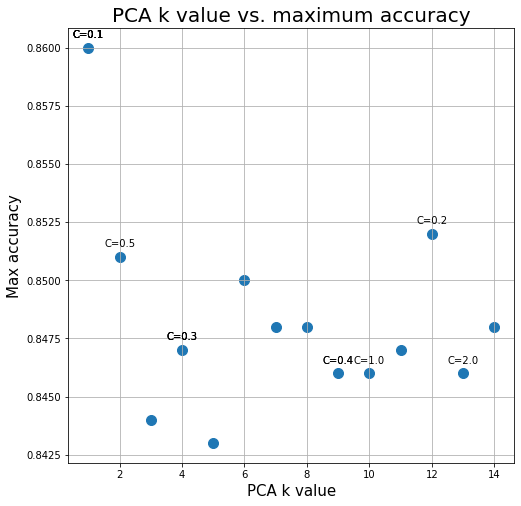

In [41]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA k value', fontsize = 15)
ax.set_ylabel('Max accuracy', fontsize = 15)
ax.set_title("PCA k value vs. maximum accuracy", fontsize = 20)
ax.scatter(k_list, accuracies, s = 100)
for c in c_vals:
    plt.annotate("C={}".format(c), (k_list[c_vals.index(c)], accuracies[c_vals.index(c)]), textcoords="offset points", xytext=(0,10), ha='center')
ax.grid()

7.5 Use L1 penalty to reduce dimensionality

In order to ensure we obtained the maximum accuracy possible with this data and logistic regression we tested using L1 penalty and the full pixel array, file size, aspect ratio, and filetype dummy variables. Although these regressions are an improvement on model 7.3, they do not out-perform models 7.4 or 7.2, with max accuracy at 84.6%

In [42]:
print("Logistic regression model with L1 penalty")
l1_model = log_reg_l1(train_data8, train_labels8, dev_data8, dev_labels8)
accuracy = l1_model[0]
max_ind = accuracy.index(max(accuracy))
c_values = [0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0]
acc_max = round(accuracy[max_ind], 3)
c_max = c_values[max_ind]
print("Features: full pixel array, size, h_to_w, filetype dummy variables")
print("Max Accuracy: {0}".format(acc_max))
print("Optimized C: {0}".format(c_max))

Logistic regression model with L1 penalty
Features: full pixel array, size, h_to_w, filetype dummy variables
Max Accuracy: 0.846
Optimized C: 0.1


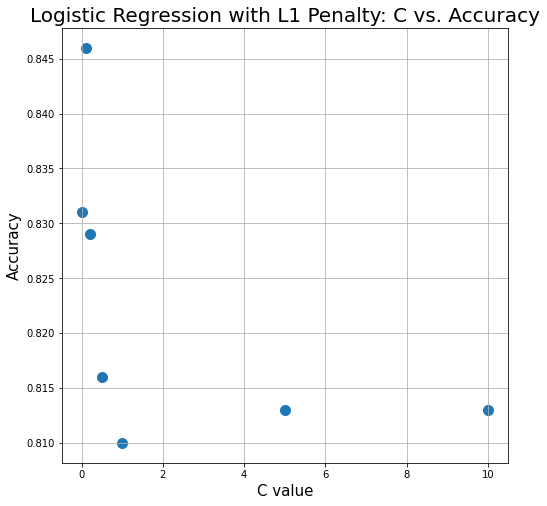

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('C value', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title("Logistic Regression with L1 Penalty: C vs. Accuracy", fontsize = 20)
ax.scatter(c_values, accuracy, s = 100)
ax.grid()

7.6 Run best logistic regression on test data

In [44]:
clf_final = LogisticRegression(C=0.1, solver='liblinear', multi_class='auto')
clf_final.fit(train_data9, train_labels9)
clf_final_pred = clf_final.predict(test_data9)
error_final = (test_labels9 != clf_final_pred).sum()/len(clf_final_pred)
acc_final = round(1-error_final,3)
print("Final logistic regression accuracy on test data: {}".format(acc_final))

Final logistic regression accuracy on test data: 0.834


**Step 8: Multilayer NN**

8.1 Build a single-layer dense neural network using Keras Tuner so that we can easily tune the hyperparameters.

In [45]:
# Instantiate the tuner to perform hypertuning using the Hyperband tuner and the model_builder function we defined initially.
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project',
                     project_name = 'keras_tuner_results')    

In [46]:
# Run the hyperparameter search
tuner.search(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Print the results
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.0001.



In [47]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9))

Train on 2252 samples, validate on 751 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 37s - loss: 0.5556 - accuracy: 0.718 - ETA: 1s - loss: 0.6643 - accuracy: 0.617 - ETA: 0s - loss: 0.6576 - accuracy: 0.60 - ETA: 0s - loss: 0.6561 - accuracy: 0.60 - 1s 442us/sample - loss: 0.6451 - accuracy: 0.6115 - val_loss: 0.6875 - val_accuracy: 0.5699
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.56 - ETA: 0s - loss: 0.6597 - accuracy: 0.58 - ETA: 0s - loss: 0.6503 - accuracy: 0.60 - ETA: 0s - loss: 0.6387 - accuracy: 0.63 - ETA: 0s - loss: 0.6309 - accuracy: 0.65 - 0s 138us/sample - loss: 0.6308 - accuracy: 0.6519 - val_loss: 0.6070 - val_accuracy: 0.6698
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.78 - ETA: 0s - loss: 0.5948 - accuracy: 0.71 - ETA: 0s - loss: 0.5987 - accuracy: 0.70 - ETA: 0s - loss: 0.5960 - accuracy: 0.70 - 0s 132us/sample - loss: 0.5949 - accuracy: 0.7131 - 

8.2 Build a multi-layer dense neural network.

In [48]:
# Run an intial model using the parameters from the Keras Tuner model and an intial dropout rate of .2
build_model_output = build_model(384, .2, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Train on 2252 samples
Epoch 1/50
2252/2252 [==============================] - ETA: 41s - loss: 32.6037 - accuracy: 0.25 - ETA: 3s - loss: 7.8283 - accuracy: 0.5521 - ETA: 1s - loss: 6.8630 - accuracy: 0.55 - ETA: 0s - loss: 5.8111 - accuracy: 0.57 - ETA: 0s - loss: 5.2718 - accuracy: 0.56 - ETA: 0s - loss: 4.9214 - accuracy: 0.57 - ETA: 0s - loss: 4.7256 - accuracy: 0.57 - 1s 416us/sample - loss: 4.5916 - accuracy: 0.5835
Epoch 2/50
2252/2252 [==============================] - ETA: 0s - loss: 6.0714 - accuracy: 0.59 - ETA: 0s - loss: 2.9176 - accuracy: 0.63 - ETA: 0s - loss: 3.2776 - accuracy: 0.62 - ETA: 0s - loss: 3.1827 - accuracy: 0.61 - ETA: 0s - loss: 3.2575 - accuracy: 0.61 - ETA: 0s - loss: 3.1325 - accuracy: 0.61 - ETA: 0s - loss: 3.1058 - accuracy: 0.62 - 0s 147us/sample - loss: 3.0724 - accuracy: 0.6288
Epoch 3/50
2252/2252 [==============================] - ETA: 0s - loss: 1.7534 - accuracy: 0.78 - ETA: 0s - loss: 2.9474 - accuracy: 0.64 - ETA: 0s - loss: 2.7257 - accuracy:

2252/2252 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.78 - ETA: 0s - loss: 0.4425 - accuracy: 0.82 - ETA: 0s - loss: 0.4189 - accuracy: 0.83 - ETA: 0s - loss: 0.4161 - accuracy: 0.82 - ETA: 0s - loss: 0.4045 - accuracy: 0.83 - ETA: 0s - loss: 0.3946 - accuracy: 0.83 - ETA: 0s - loss: 0.3919 - accuracy: 0.83 - ETA: 0s - loss: 0.4033 - accuracy: 0.82 - 0s 169us/sample - loss: 0.4037 - accuracy: 0.8242
Epoch 22/50
2252/2252 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.81 - ETA: 0s - loss: 0.4843 - accuracy: 0.79 - ETA: 0s - loss: 0.4474 - accuracy: 0.80 - ETA: 0s - loss: 0.4478 - accuracy: 0.80 - ETA: 0s - loss: 0.4466 - accuracy: 0.80 - ETA: 0s - loss: 0.4444 - accuracy: 0.80 - ETA: 0s - loss: 0.4262 - accuracy: 0.81 - 0s 167us/sample - loss: 0.4169 - accuracy: 0.8162
Epoch 23/50
2252/2252 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.78 - ETA: 0s - loss: 0.4334 - accuracy: 0.78 - ETA: 0s - loss: 0.4042 - ac

2252/2252 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.90 - ETA: 0s - loss: 0.3512 - accuracy: 0.84 - ETA: 0s - loss: 0.3559 - accuracy: 0.83 - ETA: 0s - loss: 0.3547 - accuracy: 0.83 - ETA: 0s - loss: 0.3635 - accuracy: 0.83 - ETA: 0s - loss: 0.3631 - accuracy: 0.83 - ETA: 0s - loss: 0.3566 - accuracy: 0.83 - 0s 163us/sample - loss: 0.3546 - accuracy: 0.8375
Epoch 41/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.84 - ETA: 0s - loss: 0.3786 - accuracy: 0.81 - ETA: 0s - loss: 0.3664 - accuracy: 0.82 - ETA: 0s - loss: 0.3537 - accuracy: 0.83 - ETA: 0s - loss: 0.3500 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.84 - ETA: 0s - loss: 0.3568 - accuracy: 0.84 - 0s 164us/sample - loss: 0.3653 - accuracy: 0.8339
Epoch 42/50
2252/2252 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.87 - ETA: 0s - loss: 0.3931 - accuracy: 0.80 - ETA: 0s - loss: 0.3642 - accuracy: 0.81 - ETA: 0s - loss: 0.3581 - ac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.8575233


8.3 Tune the hyperparameters to try and improve the accuracy.

In [49]:
# Optimize dropout rate
# Loop through dropout rates
dropout_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
final_accuracy_dropout_list = []

for i in dropout_list:
    build_model_output = build_model(384, i, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_dropout_list.append(final_accuracy)

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 1:04 - loss: 11.1301 - accuracy: 0.437 - ETA: 4s - loss: 4.5970 - accuracy: 0.5755  - ETA: 2s - loss: 3.8691 - accuracy: 0.54 - ETA: 1s - loss: 3.6509 - accuracy: 0.56 - ETA: 0s - loss: 3.5009 - accuracy: 0.56 - ETA: 0s - loss: 3.4103 - accuracy: 0.56 - ETA: 0s - loss: 3.2341 - accuracy: 0.57 - 1s 566us/sample - loss: 3.2213 - accuracy: 0.5746
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.9893 - accuracy: 0.62 - ETA: 0s - loss: 2.5002 - accuracy: 0.63 - ETA: 0s - loss: 2.4104 - accuracy: 0.66 - ETA: 0s - loss: 2.4240 - accuracy: 0.64 - ETA: 0s - loss: 2.4313 - accuracy: 0.64 - ETA: 0s - loss: 2.4434 - accuracy: 0.65 - ETA: 0s - loss: 2.5059 - accuracy: 0.63 - 0s 155us/sample - loss: 2.4614 - accuracy: 0.6403
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 2.6481 - accuracy: 0.62 - ETA: 0s - loss: 2.4502 - accuracy: 0.62 - ETA: 0s - loss: 2.2443 - accura

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 58s - loss: 11.4807 - accuracy: 0.28 - ETA: 4s - loss: 5.9437 - accuracy: 0.5455 - ETA: 2s - loss: 5.7341 - accuracy: 0.56 - ETA: 1s - loss: 5.6360 - accuracy: 0.55 - ETA: 0s - loss: 5.2475 - accuracy: 0.55 - ETA: 0s - loss: 5.1675 - accuracy: 0.56 - ETA: 0s - loss: 5.0347 - accuracy: 0.55 - ETA: 0s - loss: 4.7998 - accuracy: 0.56 - 1s 550us/sample - loss: 4.7531 - accuracy: 0.5675
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.1264 - accuracy: 0.53 - ETA: 0s - loss: 3.4455 - accuracy: 0.63 - ETA: 0s - loss: 3.2095 - accuracy: 0.63 - ETA: 0s - loss: 3.2186 - accuracy: 0.63 - ETA: 0s - loss: 3.1724 - accuracy: 0.63 - ETA: 0s - loss: 3.1949 - accuracy: 0.62 - ETA: 0s - loss: 3.1904 - accuracy: 0.62 - ETA: 0s - loss: 3.2894 - accuracy: 0.62 - 0s 175us/sample - loss: 3.2468 - accuracy: 0.6270
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.2176 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 1:05 - loss: 20.6934 - accuracy: 0.312 - ETA: 5s - loss: 8.2280 - accuracy: 0.4938  - ETA: 2s - loss: 7.2848 - accuracy: 0.54 - ETA: 1s - loss: 6.6445 - accuracy: 0.54 - ETA: 1s - loss: 6.1539 - accuracy: 0.54 - ETA: 0s - loss: 5.7495 - accuracy: 0.55 - ETA: 0s - loss: 5.4949 - accuracy: 0.56 - ETA: 0s - loss: 5.2681 - accuracy: 0.56 - 1s 600us/sample - loss: 5.2500 - accuracy: 0.5702
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.3783 - accuracy: 0.68 - ETA: 0s - loss: 4.1781 - accuracy: 0.60 - ETA: 0s - loss: 4.6422 - accuracy: 0.57 - ETA: 0s - loss: 4.6909 - accuracy: 0.57 - ETA: 0s - loss: 4.3000 - accuracy: 0.59 - ETA: 0s - loss: 4.0457 - accuracy: 0.60 - ETA: 0s - loss: 3.9615 - accuracy: 0.61 - ETA: 0s - loss: 3.7706 - accuracy: 0.61 - 0s 182us/sample - loss: 3.7630 - accuracy: 0.6075
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 2.4866 - accura

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 50s - loss: 18.5002 - accuracy: 0.46 - ETA: 4s - loss: 10.0302 - accuracy: 0.5000 - ETA: 2s - loss: 8.2702 - accuracy: 0.529 - ETA: 1s - loss: 7.7643 - accuracy: 0.52 - ETA: 0s - loss: 7.4293 - accuracy: 0.53 - ETA: 0s - loss: 7.3219 - accuracy: 0.53 - ETA: 0s - loss: 7.0221 - accuracy: 0.53 - ETA: 0s - loss: 6.6540 - accuracy: 0.54 - 1s 499us/sample - loss: 6.5789 - accuracy: 0.5520
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 9.6837 - accuracy: 0.50 - ETA: 0s - loss: 5.1805 - accuracy: 0.61 - ETA: 0s - loss: 5.3598 - accuracy: 0.60 - ETA: 0s - loss: 5.3534 - accuracy: 0.59 - ETA: 0s - loss: 5.0909 - accuracy: 0.59 - ETA: 0s - loss: 4.9775 - accuracy: 0.59 - ETA: 0s - loss: 4.7005 - accuracy: 0.60 - 0s 166us/sample - loss: 4.7117 - accuracy: 0.5941
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 1.8602 - accuracy: 0.65 - ETA: 0s - loss: 3.6905 - accurac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 45s - loss: 23.4191 - accuracy: 0.21 - ETA: 3s - loss: 9.4983 - accuracy: 0.5286 - ETA: 1s - loss: 8.7693 - accuracy: 0.56 - ETA: 0s - loss: 8.3615 - accuracy: 0.58 - ETA: 0s - loss: 8.2714 - accuracy: 0.57 - ETA: 0s - loss: 8.0925 - accuracy: 0.57 - ETA: 0s - loss: 7.7499 - accuracy: 0.57 - 1s 440us/sample - loss: 7.6573 - accuracy: 0.5804
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.5478 - accuracy: 0.53 - ETA: 0s - loss: 5.5100 - accuracy: 0.61 - ETA: 0s - loss: 6.0347 - accuracy: 0.58 - ETA: 0s - loss: 5.9812 - accuracy: 0.58 - ETA: 0s - loss: 5.8739 - accuracy: 0.59 - ETA: 0s - loss: 5.7288 - accuracy: 0.59 - ETA: 0s - loss: 5.6221 - accuracy: 0.59 - 0s 148us/sample - loss: 5.5327 - accuracy: 0.5946
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.0762 - accuracy: 0.71 - ETA: 0s - loss: 4.5534 - accuracy: 0.63 - ETA: 0s - loss: 3.9801 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 56s - loss: 10.6661 - accuracy: 0.56 - ETA: 3s - loss: 8.4127 - accuracy: 0.6130 - ETA: 1s - loss: 8.3922 - accuracy: 0.60 - ETA: 0s - loss: 8.3523 - accuracy: 0.58 - ETA: 0s - loss: 8.2110 - accuracy: 0.58 - ETA: 0s - loss: 8.2259 - accuracy: 0.57 - 1s 501us/sample - loss: 8.0926 - accuracy: 0.5764
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 8.6928 - accuracy: 0.53 - ETA: 0s - loss: 7.2963 - accuracy: 0.57 - ETA: 0s - loss: 6.4818 - accuracy: 0.58 - ETA: 0s - loss: 6.0846 - accuracy: 0.58 - ETA: 0s - loss: 5.7003 - accuracy: 0.59 - ETA: 0s - loss: 5.7050 - accuracy: 0.59 - ETA: 0s - loss: 5.5496 - accuracy: 0.60 - 0s 148us/sample - loss: 5.5327 - accuracy: 0.6008
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.8431 - accuracy: 0.65 - ETA: 0s - loss: 4.7699 - accuracy: 0.62 - ETA: 0s - loss: 4.7924 - accuracy: 0.61 - ETA: 0s - loss: 4.7511 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 49s - loss: 25.0834 - accuracy: 0.46 - ETA: 3s - loss: 15.1175 - accuracy: 0.4922 - ETA: 1s - loss: 13.4260 - accuracy: 0.536 - ETA: 0s - loss: 12.5869 - accuracy: 0.544 - ETA: 0s - loss: 11.8576 - accuracy: 0.550 - ETA: 0s - loss: 11.5520 - accuracy: 0.556 - ETA: 0s - loss: 10.9124 - accuracy: 0.563 - 1s 469us/sample - loss: 10.8379 - accuracy: 0.5631
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 7.7244 - accuracy: 0.56 - ETA: 0s - loss: 10.6709 - accuracy: 0.520 - ETA: 0s - loss: 9.2306 - accuracy: 0.554 - ETA: 0s - loss: 8.8526 - accuracy: 0.55 - ETA: 0s - loss: 8.3851 - accuracy: 0.56 - ETA: 0s - loss: 8.0866 - accuracy: 0.57 - ETA: 0s - loss: 7.7830 - accuracy: 0.57 - 0s 149us/sample - loss: 7.7106 - accuracy: 0.5737
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 8.4496 - accuracy: 0.59 - ETA: 0s - loss: 6.9263 - accuracy: 0.57 - ETA: 0s - loss: 6.4

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 43s - loss: 15.7676 - accuracy: 0.46 - ETA: 3s - loss: 18.4248 - accuracy: 0.5000 - ETA: 1s - loss: 15.1364 - accuracy: 0.525 - ETA: 0s - loss: 14.0559 - accuracy: 0.549 - ETA: 0s - loss: 13.6203 - accuracy: 0.562 - ETA: 0s - loss: 13.8527 - accuracy: 0.560 - ETA: 0s - loss: 13.5953 - accuracy: 0.559 - 1s 442us/sample - loss: 13.4641 - accuracy: 0.5568
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 12.5458 - accuracy: 0.531 - ETA: 0s - loss: 9.6257 - accuracy: 0.590 - ETA: 0s - loss: 9.5449 - accuracy: 0.60 - ETA: 0s - loss: 9.6681 - accuracy: 0.59 - ETA: 0s - loss: 9.6503 - accuracy: 0.58 - ETA: 0s - loss: 9.5547 - accuracy: 0.57 - ETA: 0s - loss: 9.4802 - accuracy: 0.57 - 0s 166us/sample - loss: 9.1356 - accuracy: 0.5773
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 6.7733 - accuracy: 0.56 - ETA: 0s - loss: 8.6168 - accuracy: 0.52 - ETA: 0s - loss: 7.5

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 58s - loss: 17.4361 - accuracy: 0.59 - ETA: 4s - loss: 29.6255 - accuracy: 0.4896 - ETA: 2s - loss: 25.2823 - accuracy: 0.539 - ETA: 1s - loss: 24.8739 - accuracy: 0.545 - ETA: 0s - loss: 23.4356 - accuracy: 0.555 - ETA: 0s - loss: 21.6915 - accuracy: 0.559 - ETA: 0s - loss: 21.0461 - accuracy: 0.553 - 1s 531us/sample - loss: 20.8259 - accuracy: 0.5515
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 7.5958 - accuracy: 0.62 - ETA: 0s - loss: 17.0211 - accuracy: 0.554 - ETA: 0s - loss: 16.8696 - accuracy: 0.558 - ETA: 0s - loss: 16.9632 - accuracy: 0.556 - ETA: 0s - loss: 16.1795 - accuracy: 0.552 - ETA: 0s - loss: 15.3637 - accuracy: 0.556 - ETA: 0s - loss: 14.7513 - accuracy: 0.553 - 0s 161us/sample - loss: 14.2260 - accuracy: 0.5555
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 11.3970 - accuracy: 0.687 - ETA: 0s - loss: 10.9279 - accuracy: 0.585 - ETA: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

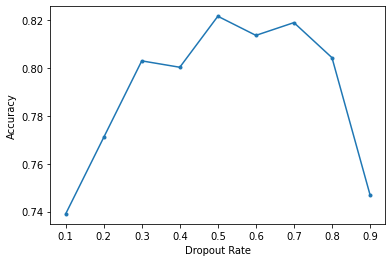

In [50]:
# Graph results
plt.plot(dropout_list, final_accuracy_dropout_list, marker = ".")
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')

In [51]:
# Looks like best dropout rate is .4, so now we will use this
# Run model using optimized dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Train on 2252 samples
Epoch 1/50
2252/2252 [==============================] - ETA: 38s - loss: 6.1617 - accuracy: 0.562 - ETA: 2s - loss: 7.0380 - accuracy: 0.575 - ETA: 1s - loss: 6.5389 - accuracy: 0.57 - ETA: 0s - loss: 6.2706 - accuracy: 0.57 - ETA: 0s - loss: 6.0547 - accuracy: 0.57 - ETA: 0s - loss: 5.9197 - accuracy: 0.57 - ETA: 0s - loss: 5.8200 - accuracy: 0.57 - 1s 394us/sample - loss: 5.8083 - accuracy: 0.5782
Epoch 2/50
2252/2252 [==============================] - ETA: 0s - loss: 8.1908 - accuracy: 0.59 - ETA: 0s - loss: 5.5901 - accuracy: 0.58 - ETA: 0s - loss: 4.6934 - accuracy: 0.60 - ETA: 0s - loss: 4.2587 - accuracy: 0.61 - ETA: 0s - loss: 4.0543 - accuracy: 0.61 - ETA: 0s - loss: 4.1111 - accuracy: 0.62 - ETA: 0s - loss: 4.0087 - accuracy: 0.62 - 0s 155us/sample - loss: 3.9338 - accuracy: 0.6261
Epoch 3/50
2252/2252 [==============================] - ETA: 0s - loss: 3.6424 - accuracy: 0.68 - ETA: 0s - loss: 3.3784 - accuracy: 0.64 - ETA: 0s - loss: 3.6027 - accuracy: 

2252/2252 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.78 - ETA: 0s - loss: 0.4162 - accuracy: 0.80 - ETA: 0s - loss: 0.4122 - accuracy: 0.80 - ETA: 0s - loss: 0.4034 - accuracy: 0.80 - ETA: 0s - loss: 0.4016 - accuracy: 0.81 - ETA: 0s - loss: 0.4057 - accuracy: 0.80 - ETA: 0s - loss: 0.4011 - accuracy: 0.80 - ETA: 0s - loss: 0.4098 - accuracy: 0.80 - 0s 169us/sample - loss: 0.4090 - accuracy: 0.8082
Epoch 21/50
2252/2252 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.84 - ETA: 0s - loss: 0.4118 - accuracy: 0.82 - ETA: 0s - loss: 0.4390 - accuracy: 0.80 - ETA: 0s - loss: 0.4313 - accuracy: 0.80 - ETA: 0s - loss: 0.4209 - accuracy: 0.81 - ETA: 0s - loss: 0.4087 - accuracy: 0.81 - ETA: 0s - loss: 0.4037 - accuracy: 0.81 - 0s 166us/sample - loss: 0.3970 - accuracy: 0.8175
Epoch 22/50
2252/2252 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.75 - ETA: 0s - loss: 0.3912 - accuracy: 0.80 - ETA: 0s - loss: 0.4275 - ac

Epoch 39/50
2252/2252 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.71 - ETA: 0s - loss: 0.3881 - accuracy: 0.81 - ETA: 0s - loss: 0.3502 - accuracy: 0.83 - ETA: 0s - loss: 0.3467 - accuracy: 0.83 - ETA: 0s - loss: 0.3600 - accuracy: 0.82 - ETA: 0s - loss: 0.3508 - accuracy: 0.83 - ETA: 0s - loss: 0.3532 - accuracy: 0.83 - ETA: 0s - loss: 0.3483 - accuracy: 0.83 - 0s 167us/sample - loss: 0.3485 - accuracy: 0.8384
Epoch 40/50
2252/2252 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.84 - ETA: 0s - loss: 0.4065 - accuracy: 0.80 - ETA: 0s - loss: 0.3768 - accuracy: 0.82 - ETA: 0s - loss: 0.3734 - accuracy: 0.82 - ETA: 0s - loss: 0.3619 - accuracy: 0.83 - ETA: 0s - loss: 0.3546 - accuracy: 0.84 - ETA: 0s - loss: 0.3551 - accuracy: 0.84 - 0s 158us/sample - loss: 0.3551 - accuracy: 0.8415
Epoch 41/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.75 - ETA: 0s - loss: 0.3004 - accuracy: 0.86 - ETA: 0s - loss:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.8069241


In [52]:
# Optimize learning rate
# Loop through learning rates
learning_rate_list = [.000001, .00001, .0001, .001, .01, .1]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(384, .4, i)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_learning_list.append(final_accuracy)

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 42s - loss: 7.3803 - accuracy: 0.500 - ETA: 3s - loss: 7.3466 - accuracy: 0.541 - ETA: 1s - loss: 7.7597 - accuracy: 0.52 - ETA: 0s - loss: 7.4266 - accuracy: 0.53 - ETA: 0s - loss: 7.5340 - accuracy: 0.53 - ETA: 0s - loss: 7.4895 - accuracy: 0.53 - ETA: 0s - loss: 7.7329 - accuracy: 0.53 - 1s 420us/sample - loss: 7.6791 - accuracy: 0.5417
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 10.5800 - accuracy: 0.500 - ETA: 0s - loss: 6.8480 - accuracy: 0.541 - ETA: 0s - loss: 6.6100 - accuracy: 0.57 - ETA: 0s - loss: 6.5384 - accuracy: 0.56 - ETA: 0s - loss: 6.7196 - accuracy: 0.56 - ETA: 0s - loss: 6.8429 - accuracy: 0.56 - ETA: 0s - loss: 7.1113 - accuracy: 0.55 - 0s 148us/sample - loss: 7.1535 - accuracy: 0.5555
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 9.1358 - accuracy: 0.56 - ETA: 0s - loss: 7.9319 - accuracy: 0.54 - ETA: 0s - loss: 7.3030 - accurac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 58s - loss: 18.1601 - accuracy: 0.43 - ETA: 4s - loss: 11.8143 - accuracy: 0.4635 - ETA: 1s - loss: 12.1250 - accuracy: 0.460 - ETA: 1s - loss: 11.8877 - accuracy: 0.476 - ETA: 0s - loss: 12.0084 - accuracy: 0.479 - ETA: 0s - loss: 11.6801 - accuracy: 0.477 - ETA: 0s - loss: 11.8379 - accuracy: 0.474 - 1s 519us/sample - loss: 11.6876 - accuracy: 0.4756
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 14.5789 - accuracy: 0.500 - ETA: 0s - loss: 9.6063 - accuracy: 0.531 - ETA: 0s - loss: 9.5986 - accuracy: 0.53 - ETA: 0s - loss: 9.9126 - accuracy: 0.52 - ETA: 0s - loss: 9.8888 - accuracy: 0.51 - ETA: 0s - loss: 9.8345 - accuracy: 0.51 - ETA: 0s - loss: 9.8635 - accuracy: 0.51 - 0s 152us/sample - loss: 9.7981 - accuracy: 0.5120
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 15.0624 - accuracy: 0.437 - ETA: 0s - loss: 8.6750 - accuracy: 0.539 - ETA: 0s - loss: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 40s - loss: 6.3467 - accuracy: 0.562 - ETA: 2s - loss: 5.3249 - accuracy: 0.572 - ETA: 1s - loss: 5.8943 - accuracy: 0.55 - ETA: 0s - loss: 5.9761 - accuracy: 0.56 - ETA: 0s - loss: 5.9574 - accuracy: 0.56 - ETA: 0s - loss: 6.0849 - accuracy: 0.55 - ETA: 0s - loss: 6.1491 - accuracy: 0.55 - 1s 407us/sample - loss: 6.1196 - accuracy: 0.5551
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 7.6257 - accuracy: 0.50 - ETA: 0s - loss: 6.0275 - accuracy: 0.53 - ETA: 0s - loss: 5.6380 - accuracy: 0.55 - ETA: 0s - loss: 5.5951 - accuracy: 0.55 - ETA: 0s - loss: 5.6135 - accuracy: 0.56 - ETA: 0s - loss: 5.5697 - accuracy: 0.55 - ETA: 0s - loss: 5.6794 - accuracy: 0.55 - ETA: 0s - loss: 5.7733 - accuracy: 0.55 - 0s 172us/sample - loss: 5.7061 - accuracy: 0.5595
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 6.6715 - accuracy: 0.56 - ETA: 0s - loss: 6.1002 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 41s - loss: 9.9420 - accuracy: 0.437 - ETA: 3s - loss: 9.7230 - accuracy: 0.518 - ETA: 1s - loss: 7.9816 - accuracy: 0.54 - ETA: 0s - loss: 7.4350 - accuracy: 0.56 - ETA: 0s - loss: 7.0132 - accuracy: 0.57 - ETA: 0s - loss: 6.6486 - accuracy: 0.57 - ETA: 0s - loss: 6.4862 - accuracy: 0.58 - 1s 419us/sample - loss: 6.4009 - accuracy: 0.5786
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.4715 - accuracy: 0.65 - ETA: 0s - loss: 4.6164 - accuracy: 0.60 - ETA: 0s - loss: 4.8906 - accuracy: 0.61 - ETA: 0s - loss: 4.5930 - accuracy: 0.61 - ETA: 0s - loss: 4.5462 - accuracy: 0.62 - ETA: 0s - loss: 4.4323 - accuracy: 0.62 - ETA: 0s - loss: 4.4835 - accuracy: 0.61 - ETA: 0s - loss: 4.4487 - accuracy: 0.61 - 0s 170us/sample - loss: 4.4002 - accuracy: 0.6186
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 7.3236 - accuracy: 0.50 - ETA: 0s - loss: 3.8309 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 44s - loss: 5.2301 - accuracy: 0.531 - ETA: 3s - loss: 13.1191 - accuracy: 0.580 - ETA: 1s - loss: 11.7353 - accuracy: 0.578 - ETA: 0s - loss: 10.8115 - accuracy: 0.587 - ETA: 0s - loss: 9.0571 - accuracy: 0.601 - ETA: 0s - loss: 8.0375 - accuracy: 0.60 - ETA: 0s - loss: 7.0528 - accuracy: 0.61 - ETA: 0s - loss: 6.7552 - accuracy: 0.62 - 1s 456us/sample - loss: 6.5721 - accuracy: 0.6234
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 2.6381 - accuracy: 0.71 - ETA: 0s - loss: 2.0142 - accuracy: 0.69 - ETA: 0s - loss: 1.6443 - accuracy: 0.70 - ETA: 0s - loss: 1.4301 - accuracy: 0.71 - ETA: 0s - loss: 1.3013 - accuracy: 0.72 - ETA: 0s - loss: 1.2201 - accuracy: 0.72 - ETA: 0s - loss: 1.1382 - accuracy: 0.72 - 0s 158us/sample - loss: 1.0976 - accuracy: 0.7300
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.62 - ETA: 0s - loss: 0.6861 - accu

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 40s - loss: 11.5307 - accuracy: 0.46 - ETA: 3s - loss: 219.1168 - accuracy: 0.54 - ETA: 1s - loss: 176.5232 - accuracy: 0.55 - ETA: 0s - loss: 142.5801 - accuracy: 0.57 - ETA: 0s - loss: 125.2039 - accuracy: 0.58 - ETA: 0s - loss: 111.9913 - accuracy: 0.59 - ETA: 0s - loss: 99.2269 - accuracy: 0.6043 - 1s 405us/sample - loss: 98.0914 - accuracy: 0.6035
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 89.9985 - accuracy: 0.687 - ETA: 0s - loss: 69.9863 - accuracy: 0.679 - ETA: 0s - loss: 68.5443 - accuracy: 0.694 - ETA: 0s - loss: 65.5966 - accuracy: 0.690 - ETA: 0s - loss: 60.5671 - accuracy: 0.688 - ETA: 0s - loss: 67.9462 - accuracy: 0.683 - ETA: 0s - loss: 64.2142 - accuracy: 0.681 - 0s 151us/sample - loss: 62.2995 - accuracy: 0.6829
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 16.6864 - accuracy: 0.687 - ETA: 0s - loss: 45.1411 - accuracy: 0.737 - ETA

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

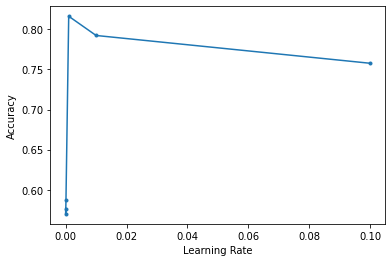

In [53]:
# Graph results
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

In [54]:
# Looks like best learning rate is .001, so now we will use this
# Run model using learning dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Train on 2252 samples
Epoch 1/50
2252/2252 [==============================] - ETA: 53s - loss: 13.5416 - accuracy: 0.56 - ETA: 3s - loss: 6.5919 - accuracy: 0.5573 - ETA: 1s - loss: 7.0680 - accuracy: 0.56 - ETA: 1s - loss: 6.7934 - accuracy: 0.56 - ETA: 0s - loss: 6.6558 - accuracy: 0.56 - ETA: 0s - loss: 6.7387 - accuracy: 0.56 - ETA: 0s - loss: 6.6417 - accuracy: 0.55 - 1s 502us/sample - loss: 6.4956 - accuracy: 0.5622
Epoch 2/50
2252/2252 [==============================] - ETA: 0s - loss: 8.7058 - accuracy: 0.59 - ETA: 0s - loss: 5.4884 - accuracy: 0.58 - ETA: 0s - loss: 4.9716 - accuracy: 0.59 - ETA: 0s - loss: 4.5607 - accuracy: 0.60 - ETA: 0s - loss: 4.6326 - accuracy: 0.60 - ETA: 0s - loss: 4.4875 - accuracy: 0.60 - ETA: 0s - loss: 4.4518 - accuracy: 0.59 - 0s 163us/sample - loss: 4.3285 - accuracy: 0.6039
Epoch 3/50
2252/2252 [==============================] - ETA: 0s - loss: 4.6143 - accuracy: 0.56 - ETA: 0s - loss: 3.6172 - accuracy: 0.64 - ETA: 0s - loss: 3.5527 - accuracy:

2252/2252 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.84 - ETA: 0s - loss: 0.3890 - accuracy: 0.80 - ETA: 0s - loss: 0.3919 - accuracy: 0.80 - ETA: 0s - loss: 0.3910 - accuracy: 0.80 - ETA: 0s - loss: 0.3920 - accuracy: 0.80 - ETA: 0s - loss: 0.3834 - accuracy: 0.80 - ETA: 0s - loss: 0.3870 - accuracy: 0.80 - ETA: 0s - loss: 0.3832 - accuracy: 0.81 - ETA: 0s - loss: 0.3844 - accuracy: 0.81 - ETA: 0s - loss: 0.3858 - accuracy: 0.81 - ETA: 0s - loss: 0.3922 - accuracy: 0.81 - ETA: 0s - loss: 0.3939 - accuracy: 0.81 - ETA: 0s - loss: 0.3898 - accuracy: 0.81 - 1s 305us/sample - loss: 0.3890 - accuracy: 0.8135
Epoch 20/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.81 - ETA: 0s - loss: 0.3813 - accuracy: 0.80 - ETA: 0s - loss: 0.4068 - accuracy: 0.81 - ETA: 0s - loss: 0.4018 - accuracy: 0.81 - ETA: 0s - loss: 0.3994 - accuracy: 0.81 - ETA: 0s - loss: 0.3977 - accuracy: 0.81 - ETA: 0s - loss: 0.3972 - accuracy: 0.81 - ETA: 0s 

2252/2252 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.81 - ETA: 0s - loss: 0.3240 - accuracy: 0.85 - ETA: 0s - loss: 0.3518 - accuracy: 0.84 - ETA: 0s - loss: 0.3527 - accuracy: 0.84 - ETA: 0s - loss: 0.3593 - accuracy: 0.83 - ETA: 0s - loss: 0.3603 - accuracy: 0.84 - ETA: 0s - loss: 0.3612 - accuracy: 0.83 - ETA: 0s - loss: 0.3619 - accuracy: 0.83 - ETA: 0s - loss: 0.3614 - accuracy: 0.83 - 0s 195us/sample - loss: 0.3606 - accuracy: 0.8335
Epoch 37/50
2252/2252 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.93 - ETA: 0s - loss: 0.3468 - accuracy: 0.84 - ETA: 0s - loss: 0.3464 - accuracy: 0.84 - ETA: 0s - loss: 0.3419 - accuracy: 0.84 - ETA: 0s - loss: 0.3368 - accuracy: 0.85 - ETA: 0s - loss: 0.3503 - accuracy: 0.84 - ETA: 0s - loss: 0.3526 - accuracy: 0.83 - ETA: 0s - loss: 0.3550 - accuracy: 0.83 - 0s 192us/sample - loss: 0.3631 - accuracy: 0.8321
Epoch 38/50
2252/2252 [==============================] - ETA: 0s - loss: 0.3808 - ac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.87217045


In [55]:
# Try different numbers of nodes - keeping dropout at .3 and learning rate at .001

#Loop through nodes
final_accuracy_node_list = []

for i in range(1, 550, 50):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 42s - loss: 25.7148 - accuracy: 0.37 - ETA: 1s - loss: 18.0257 - accuracy: 0.4938 - ETA: 0s - loss: 17.1243 - accuracy: 0.490 - ETA: 0s - loss: 15.8926 - accuracy: 0.493 - 1s 344us/sample - loss: 15.5539 - accuracy: 0.4982
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 16.0802 - accuracy: 0.531 - ETA: 0s - loss: 9.7308 - accuracy: 0.492 - ETA: 0s - loss: 8.6935 - accuracy: 0.49 - 0s 65us/sample - loss: 7.8530 - accuracy: 0.4960
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.9481 - accuracy: 0.53 - ETA: 0s - loss: 3.9657 - accuracy: 0.47 - ETA: 0s - loss: 3.1563 - accuracy: 0.49 - 0s 65us/sample - loss: 2.4815 - accuracy: 0.5027
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss: 0.8102 - accuracy: 0.56 - ETA: 0s - loss: 0.6754 - accuracy: 0.59 - ETA: 0s - loss: 0.6597 - accuracy: 0.60 - 0s 64us/sample - loss: 0.6615 - accuracy: 0.595

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 52s - loss: 24.3633 - accuracy: 0.56 - ETA: 1s - loss: 27.7736 - accuracy: 0.4647 - ETA: 0s - loss: 21.1743 - accuracy: 0.502 - ETA: 0s - loss: 18.1262 - accuracy: 0.524 - 1s 408us/sample - loss: 18.1237 - accuracy: 0.5235
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 16.7376 - accuracy: 0.468 - ETA: 0s - loss: 12.3108 - accuracy: 0.561 - ETA: 0s - loss: 11.6155 - accuracy: 0.571 - 0s 66us/sample - loss: 11.3943 - accuracy: 0.5662
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 10.7802 - accuracy: 0.531 - ETA: 0s - loss: 9.9460 - accuracy: 0.562 - ETA: 0s - loss: 9.1413 - accuracy: 0.57 - 0s 64us/sample - loss: 8.7829 - accuracy: 0.5786
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss: 4.4898 - accuracy: 0.68 - ETA: 0s - loss: 6.3763 - accuracy: 0.61 - ETA: 0s - loss: 6.4941 - accuracy: 0.59 - 0s 61us/sample - loss: 6.1873 - accuracy

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 35s - loss: 25.3387 - accuracy: 0.59 - ETA: 1s - loss: 13.3660 - accuracy: 0.5357 - ETA: 0s - loss: 12.3144 - accuracy: 0.558 - ETA: 0s - loss: 11.3315 - accuracy: 0.568 - 1s 301us/sample - loss: 11.1803 - accuracy: 0.5653
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 8.9809 - accuracy: 0.40 - ETA: 0s - loss: 8.8517 - accuracy: 0.57 - ETA: 0s - loss: 8.1661 - accuracy: 0.57 - ETA: 0s - loss: 7.7178 - accuracy: 0.57 - 0s 72us/sample - loss: 7.6995 - accuracy: 0.5764
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.6879 - accuracy: 0.50 - ETA: 0s - loss: 6.8306 - accuracy: 0.56 - ETA: 0s - loss: 6.3475 - accuracy: 0.58 - ETA: 0s - loss: 5.7768 - accuracy: 0.58 - 0s 72us/sample - loss: 5.7660 - accuracy: 0.5808
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss: 4.2426 - accuracy: 0.65 - ETA: 0s - loss: 4.0991 - accuracy: 0.62 - ETA: 0s 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 34s - loss: 14.6479 - accuracy: 0.62 - ETA: 1s - loss: 10.2753 - accuracy: 0.5699 - ETA: 0s - loss: 9.6845 - accuracy: 0.564 - ETA: 0s - loss: 9.5024 - accuracy: 0.55 - 1s 298us/sample - loss: 9.2798 - accuracy: 0.5542
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 15.5194 - accuracy: 0.593 - ETA: 0s - loss: 8.2426 - accuracy: 0.589 - ETA: 0s - loss: 7.5975 - accuracy: 0.58 - ETA: 0s - loss: 7.1155 - accuracy: 0.59 - 0s 71us/sample - loss: 7.1124 - accuracy: 0.5972
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 8.2976 - accuracy: 0.59 - ETA: 0s - loss: 5.1993 - accuracy: 0.61 - ETA: 0s - loss: 5.0910 - accuracy: 0.60 - 0s 70us/sample - loss: 4.9050 - accuracy: 0.6101
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss: 3.8810 - accuracy: 0.62 - ETA: 0s - loss: 3.8474 - accuracy: 0.64 - ETA: 0s - loss: 3.6388 - accuracy: 0.65 - ETA: 0s -

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 33s - loss: 50.3481 - accuracy: 0.28 - ETA: 1s - loss: 15.8992 - accuracy: 0.5378 - ETA: 0s - loss: 13.2650 - accuracy: 0.541 - ETA: 0s - loss: 11.9431 - accuracy: 0.546 - 1s 298us/sample - loss: 11.0986 - accuracy: 0.5524
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 12.2002 - accuracy: 0.437 - ETA: 0s - loss: 7.2667 - accuracy: 0.546 - ETA: 0s - loss: 6.8843 - accuracy: 0.56 - ETA: 0s - loss: 6.6131 - accuracy: 0.58 - 0s 83us/sample - loss: 6.4986 - accuracy: 0.5848
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 7.6868 - accuracy: 0.56 - ETA: 0s - loss: 6.1641 - accuracy: 0.58 - ETA: 0s - loss: 5.7137 - accuracy: 0.59 - ETA: 0s - loss: 5.6125 - accuracy: 0.59 - 0s 81us/sample - loss: 5.4581 - accuracy: 0.5977
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss: 3.3972 - accuracy: 0.50 - ETA: 0s - loss: 4.3476 - accuracy: 0.61 - ETA: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 54s - loss: 11.9197 - accuracy: 0.43 - ETA: 2s - loss: 9.5596 - accuracy: 0.5147 - ETA: 0s - loss: 8.6303 - accuracy: 0.56 - ETA: 0s - loss: 8.1016 - accuracy: 0.54 - 1s 442us/sample - loss: 7.8810 - accuracy: 0.5622
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 10.8941 - accuracy: 0.625 - ETA: 0s - loss: 6.8016 - accuracy: 0.590 - ETA: 0s - loss: 6.4608 - accuracy: 0.59 - ETA: 0s - loss: 6.4801 - accuracy: 0.59 - ETA: 0s - loss: 6.2602 - accuracy: 0.58 - 0s 103us/sample - loss: 6.1957 - accuracy: 0.5941
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 2.9900 - accuracy: 0.62 - ETA: 0s - loss: 5.4661 - accuracy: 0.56 - ETA: 0s - loss: 4.6739 - accuracy: 0.60 - ETA: 0s - loss: 4.7420 - accuracy: 0.59 - ETA: 0s - loss: 4.5398 - accuracy: 0.60 - 0s 98us/sample - loss: 4.4944 - accuracy: 0.6106
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 39s - loss: 26.1240 - accuracy: 0.28 - ETA: 2s - loss: 9.9940 - accuracy: 0.4980 - ETA: 0s - loss: 9.2129 - accuracy: 0.55 - ETA: 0s - loss: 8.6685 - accuracy: 0.55 - ETA: 0s - loss: 8.0531 - accuracy: 0.56 - 1s 355us/sample - loss: 7.8375 - accuracy: 0.5684
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 10.8724 - accuracy: 0.468 - ETA: 0s - loss: 6.5508 - accuracy: 0.611 - ETA: 0s - loss: 6.2423 - accuracy: 0.60 - ETA: 0s - loss: 5.6878 - accuracy: 0.60 - ETA: 0s - loss: 5.7616 - accuracy: 0.60 - 0s 106us/sample - loss: 5.6501 - accuracy: 0.6030
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.6253 - accuracy: 0.62 - ETA: 0s - loss: 4.4320 - accuracy: 0.64 - ETA: 0s - loss: 4.7036 - accuracy: 0.63 - ETA: 0s - loss: 4.5964 - accuracy: 0.63 - ETA: 0s - loss: 4.2923 - accuracy: 0.63 - 0s 104us/sample - loss: 4.2983 - accuracy: 0.6341
Epoch 4/10
2252/2252 [=

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 41s - loss: 8.5886 - accuracy: 0.531 - ETA: 5s - loss: 8.6984 - accuracy: 0.531 - ETA: 2s - loss: 7.6572 - accuracy: 0.54 - ETA: 1s - loss: 7.5097 - accuracy: 0.54 - ETA: 0s - loss: 7.0974 - accuracy: 0.54 - ETA: 0s - loss: 6.5865 - accuracy: 0.55 - ETA: 0s - loss: 6.3585 - accuracy: 0.56 - ETA: 0s - loss: 6.0311 - accuracy: 0.57 - 1s 431us/sample - loss: 5.9994 - accuracy: 0.5733
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 2.9851 - accuracy: 0.56 - ETA: 0s - loss: 4.6035 - accuracy: 0.59 - ETA: 0s - loss: 4.0010 - accuracy: 0.61 - ETA: 0s - loss: 4.0854 - accuracy: 0.61 - ETA: 0s - loss: 4.1914 - accuracy: 0.60 - ETA: 0s - loss: 4.1288 - accuracy: 0.60 - 0s 140us/sample - loss: 4.0826 - accuracy: 0.6052
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 2.3379 - accuracy: 0.68 - ETA: 0s - loss: 3.0891 - accuracy: 0.61 - ETA: 0s - loss: 3.1457 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 42s - loss: 9.9156 - accuracy: 0.562 - ETA: 3s - loss: 6.4155 - accuracy: 0.590 - ETA: 1s - loss: 6.9987 - accuracy: 0.55 - ETA: 1s - loss: 6.7618 - accuracy: 0.57 - ETA: 0s - loss: 6.4071 - accuracy: 0.58 - ETA: 0s - loss: 6.2157 - accuracy: 0.58 - ETA: 0s - loss: 5.9910 - accuracy: 0.59 - ETA: 0s - loss: 5.8962 - accuracy: 0.59 - 1s 447us/sample - loss: 5.8346 - accuracy: 0.5946
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 6.8743 - accuracy: 0.53 - ETA: 0s - loss: 5.4187 - accuracy: 0.57 - ETA: 0s - loss: 4.7496 - accuracy: 0.60 - ETA: 0s - loss: 4.7364 - accuracy: 0.59 - ETA: 0s - loss: 4.6825 - accuracy: 0.58 - ETA: 0s - loss: 4.4125 - accuracy: 0.59 - ETA: 0s - loss: 4.3659 - accuracy: 0.60 - ETA: 0s - loss: 4.3303 - accuracy: 0.60 - ETA: 0s - loss: 4.2710 - accuracy: 0.60 - 0s 206us/sample - loss: 4.3396 - accuracy: 0.6021
Epoch 3/10
2252/2252 [===========================

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 1:06 - loss: 11.4874 - accuracy: 0.312 - ETA: 5s - loss: 7.1789 - accuracy: 0.5597  - ETA: 2s - loss: 6.8118 - accuracy: 0.58 - ETA: 1s - loss: 6.4944 - accuracy: 0.58 - ETA: 0s - loss: 6.3576 - accuracy: 0.57 - ETA: 0s - loss: 6.1606 - accuracy: 0.57 - ETA: 0s - loss: 6.1040 - accuracy: 0.57 - ETA: 0s - loss: 5.9599 - accuracy: 0.58 - ETA: 0s - loss: 5.9131 - accuracy: 0.58 - 1s 637us/sample - loss: 5.7761 - accuracy: 0.5857
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.7883 - accuracy: 0.65 - ETA: 0s - loss: 4.4877 - accuracy: 0.64 - ETA: 0s - loss: 4.4820 - accuracy: 0.62 - ETA: 0s - loss: 4.3021 - accuracy: 0.60 - ETA: 0s - loss: 4.4103 - accuracy: 0.61 - ETA: 0s - loss: 4.2068 - accuracy: 0.62 - ETA: 0s - loss: 4.1639 - accuracy: 0.61 - ETA: 0s - loss: 4.1165 - accuracy: 0.61 - 0s 190us/sample - loss: 4.1147 - accuracy: 0.6194
Epoch 3/10
2252/2252 [=======================

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 38s - loss: 21.5855 - accuracy: 0.59 - ETA: 2s - loss: 11.5474 - accuracy: 0.4896 - ETA: 1s - loss: 10.0404 - accuracy: 0.527 - ETA: 1s - loss: 9.3762 - accuracy: 0.544 - ETA: 0s - loss: 8.5953 - accuracy: 0.55 - ETA: 0s - loss: 8.1590 - accuracy: 0.55 - ETA: 0s - loss: 7.5768 - accuracy: 0.56 - ETA: 0s - loss: 7.1348 - accuracy: 0.56 - 1s 423us/sample - loss: 7.0473 - accuracy: 0.5702
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.3235 - accuracy: 0.62 - ETA: 0s - loss: 4.5724 - accuracy: 0.57 - ETA: 0s - loss: 4.2685 - accuracy: 0.60 - ETA: 0s - loss: 4.3074 - accuracy: 0.60 - ETA: 0s - loss: 4.1459 - accuracy: 0.61 - ETA: 0s - loss: 4.1989 - accuracy: 0.60 - ETA: 0s - loss: 4.1845 - accuracy: 0.60 - 0s 164us/sample - loss: 4.0018 - accuracy: 0.6119
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.4532 - accuracy: 0.71 - ETA: 0s - loss: 3.8944 - accur

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

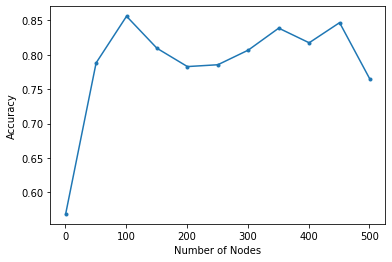

In [56]:
#Graph the results
plt.plot(range(1,550,50), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [57]:
# It looks like best value is somewhere between 300 and 450
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(300, 450, 25):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 40s - loss: 13.2388 - accuracy: 0.50 - ETA: 2s - loss: 9.0302 - accuracy: 0.5586 - ETA: 0s - loss: 8.1943 - accuracy: 0.54 - ETA: 0s - loss: 7.6010 - accuracy: 0.54 - ETA: 0s - loss: 7.3380 - accuracy: 0.54 - 1s 364us/sample - loss: 7.0231 - accuracy: 0.5577
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.5642 - accuracy: 0.50 - ETA: 0s - loss: 5.1629 - accuracy: 0.61 - ETA: 0s - loss: 5.3796 - accuracy: 0.61 - ETA: 0s - loss: 5.2143 - accuracy: 0.60 - ETA: 0s - loss: 5.0202 - accuracy: 0.60 - 0s 108us/sample - loss: 4.7647 - accuracy: 0.6146
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.4239 - accuracy: 0.59 - ETA: 0s - loss: 3.9367 - accuracy: 0.63 - ETA: 0s - loss: 3.9328 - accuracy: 0.62 - ETA: 0s - loss: 3.5077 - accuracy: 0.64 - ETA: 0s - loss: 3.5052 - accuracy: 0.64 - 0s 106us/sample - loss: 3.5553 - accuracy: 0.6385
Epoch 4/10
2252/2252 [====

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 34s - loss: 7.2768 - accuracy: 0.687 - ETA: 1s - loss: 7.4025 - accuracy: 0.553 - ETA: 0s - loss: 7.1472 - accuracy: 0.55 - ETA: 0s - loss: 6.8335 - accuracy: 0.55 - ETA: 0s - loss: 6.6004 - accuracy: 0.55 - 1s 317us/sample - loss: 6.6340 - accuracy: 0.5577
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.2852 - accuracy: 0.65 - ETA: 0s - loss: 5.6365 - accuracy: 0.56 - ETA: 0s - loss: 5.4478 - accuracy: 0.58 - ETA: 0s - loss: 5.2301 - accuracy: 0.58 - 0s 91us/sample - loss: 4.8563 - accuracy: 0.5897
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.2774 - accuracy: 0.59 - ETA: 0s - loss: 3.2308 - accuracy: 0.63 - ETA: 0s - loss: 3.5950 - accuracy: 0.62 - ETA: 0s - loss: 3.4187 - accuracy: 0.62 - ETA: 0s - loss: 3.2220 - accuracy: 0.63 - 0s 95us/sample - loss: 3.2128 - accuracy: 0.6359
Epoch 4/10
2252/2252 [==============================] - ETA: 0s - loss:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 50s - loss: 25.8689 - accuracy: 0.50 - ETA: 2s - loss: 10.0721 - accuracy: 0.5708 - ETA: 1s - loss: 8.7122 - accuracy: 0.545 - ETA: 0s - loss: 8.3283 - accuracy: 0.55 - ETA: 0s - loss: 7.8261 - accuracy: 0.56 - ETA: 0s - loss: 7.3211 - accuracy: 0.57 - 1s 441us/sample - loss: 7.2934 - accuracy: 0.5790
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 8.2708 - accuracy: 0.59 - ETA: 0s - loss: 5.4863 - accuracy: 0.62 - ETA: 0s - loss: 5.4160 - accuracy: 0.62 - ETA: 0s - loss: 5.3911 - accuracy: 0.62 - ETA: 0s - loss: 5.3800 - accuracy: 0.62 - ETA: 0s - loss: 5.3673 - accuracy: 0.61 - 0s 121us/sample - loss: 5.3706 - accuracy: 0.6181
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.1420 - accuracy: 0.53 - ETA: 0s - loss: 5.3141 - accuracy: 0.57 - ETA: 0s - loss: 5.0902 - accuracy: 0.59 - ETA: 0s - loss: 4.7954 - accuracy: 0.59 - ETA: 0s - loss: 4.5175 - accurac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 36s - loss: 3.5684 - accuracy: 0.531 - ETA: 2s - loss: 6.9864 - accuracy: 0.549 - ETA: 1s - loss: 6.9415 - accuracy: 0.54 - ETA: 0s - loss: 6.6335 - accuracy: 0.55 - ETA: 0s - loss: 6.1200 - accuracy: 0.57 - ETA: 0s - loss: 6.1650 - accuracy: 0.57 - 1s 371us/sample - loss: 6.0868 - accuracy: 0.5835
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.0983 - accuracy: 0.65 - ETA: 0s - loss: 4.9633 - accuracy: 0.58 - ETA: 0s - loss: 4.7302 - accuracy: 0.61 - ETA: 0s - loss: 4.8896 - accuracy: 0.60 - ETA: 0s - loss: 4.9531 - accuracy: 0.60 - ETA: 0s - loss: 4.7916 - accuracy: 0.60 - 0s 135us/sample - loss: 4.6523 - accuracy: 0.6097
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.5514 - accuracy: 0.50 - ETA: 0s - loss: 3.0382 - accuracy: 0.63 - ETA: 0s - loss: 3.0803 - accuracy: 0.63 - ETA: 0s - loss: 3.2043 - accuracy: 0.63 - ETA: 0s - loss: 3.2839 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 38s - loss: 7.0869 - accuracy: 0.531 - ETA: 2s - loss: 5.9245 - accuracy: 0.570 - ETA: 1s - loss: 6.4768 - accuracy: 0.57 - ETA: 0s - loss: 6.1677 - accuracy: 0.57 - ETA: 0s - loss: 6.1235 - accuracy: 0.57 - ETA: 0s - loss: 6.2453 - accuracy: 0.58 - ETA: 0s - loss: 6.1001 - accuracy: 0.58 - 1s 389us/sample - loss: 6.0108 - accuracy: 0.5804
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.3041 - accuracy: 0.56 - ETA: 0s - loss: 4.9885 - accuracy: 0.57 - ETA: 0s - loss: 4.6858 - accuracy: 0.59 - ETA: 0s - loss: 4.6824 - accuracy: 0.60 - ETA: 0s - loss: 4.6665 - accuracy: 0.60 - ETA: 0s - loss: 4.5606 - accuracy: 0.60 - ETA: 0s - loss: 4.4513 - accuracy: 0.60 - 0s 154us/sample - loss: 4.3652 - accuracy: 0.6057
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.2479 - accuracy: 0.56 - ETA: 0s - loss: 3.1867 - accuracy: 0.62 - ETA: 0s - loss: 3.0777 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 38s - loss: 38.8722 - accuracy: 0.40 - ETA: 2s - loss: 16.5228 - accuracy: 0.4609 - ETA: 1s - loss: 13.1064 - accuracy: 0.516 - ETA: 0s - loss: 11.0362 - accuracy: 0.541 - ETA: 0s - loss: 9.9185 - accuracy: 0.545 - ETA: 0s - loss: 9.0290 - accuracy: 0.54 - ETA: 0s - loss: 8.4267 - accuracy: 0.55 - 1s 394us/sample - loss: 8.2731 - accuracy: 0.5528
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.9744 - accuracy: 0.68 - ETA: 0s - loss: 5.3432 - accuracy: 0.58 - ETA: 0s - loss: 5.0783 - accuracy: 0.61 - ETA: 0s - loss: 5.0957 - accuracy: 0.59 - ETA: 0s - loss: 4.9867 - accuracy: 0.59 - ETA: 0s - loss: 4.9620 - accuracy: 0.58 - ETA: 0s - loss: 4.8288 - accuracy: 0.59 - 0s 150us/sample - loss: 4.8298 - accuracy: 0.5950
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.8019 - accuracy: 0.46 - ETA: 0s - loss: 4.0485 - accuracy: 0.56 - ETA: 0s - loss: 4.1012 - acc

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

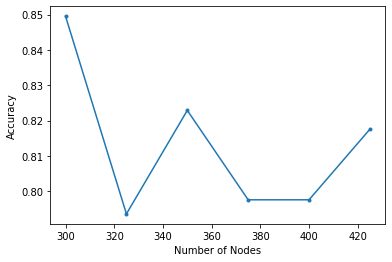

In [58]:
#Graph results
plt.plot(range(300, 450, 25), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [59]:
# It looks like best value is somewhere between 375 and 425
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(375, 425, 10):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)


Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 39s - loss: 4.9747 - accuracy: 0.625 - ETA: 2s - loss: 6.9133 - accuracy: 0.524 - ETA: 1s - loss: 7.2039 - accuracy: 0.51 - ETA: 0s - loss: 7.1578 - accuracy: 0.52 - ETA: 0s - loss: 6.8510 - accuracy: 0.55 - ETA: 0s - loss: 6.5433 - accuracy: 0.55 - ETA: 0s - loss: 6.3452 - accuracy: 0.56 - 1s 395us/sample - loss: 6.2928 - accuracy: 0.5684
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 7.4695 - accuracy: 0.43 - ETA: 0s - loss: 6.0122 - accuracy: 0.54 - ETA: 0s - loss: 5.4850 - accuracy: 0.59 - ETA: 0s - loss: 5.2346 - accuracy: 0.58 - ETA: 0s - loss: 5.0113 - accuracy: 0.59 - ETA: 0s - loss: 4.8105 - accuracy: 0.58 - ETA: 0s - loss: 4.7936 - accuracy: 0.59 - 0s 151us/sample - loss: 4.7125 - accuracy: 0.5964
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.1845 - accuracy: 0.68 - ETA: 0s - loss: 3.4154 - accuracy: 0.62 - ETA: 0s - loss: 3.4782 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 37s - loss: 5.6780 - accuracy: 0.593 - ETA: 2s - loss: 6.6187 - accuracy: 0.531 - ETA: 1s - loss: 6.8431 - accuracy: 0.55 - ETA: 0s - loss: 6.7834 - accuracy: 0.53 - ETA: 0s - loss: 6.5872 - accuracy: 0.54 - ETA: 0s - loss: 6.2508 - accuracy: 0.55 - 1s 372us/sample - loss: 6.1069 - accuracy: 0.5586
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.0445 - accuracy: 0.62 - ETA: 0s - loss: 4.8500 - accuracy: 0.61 - ETA: 0s - loss: 4.9404 - accuracy: 0.58 - ETA: 0s - loss: 4.7295 - accuracy: 0.60 - ETA: 0s - loss: 4.6500 - accuracy: 0.60 - ETA: 0s - loss: 4.4950 - accuracy: 0.61 - 0s 133us/sample - loss: 4.4215 - accuracy: 0.6186
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.4360 - accuracy: 0.68 - ETA: 0s - loss: 3.8971 - accuracy: 0.63 - ETA: 0s - loss: 3.5483 - accuracy: 0.65 - ETA: 0s - loss: 3.5511 - accuracy: 0.64 - ETA: 0s - loss: 3.4849 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 37s - loss: 19.4704 - accuracy: 0.46 - ETA: 2s - loss: 9.1654 - accuracy: 0.5337 - ETA: 1s - loss: 7.3111 - accuracy: 0.57 - ETA: 0s - loss: 6.8929 - accuracy: 0.58 - ETA: 0s - loss: 6.8880 - accuracy: 0.57 - ETA: 0s - loss: 6.5438 - accuracy: 0.57 - 1s 376us/sample - loss: 6.4215 - accuracy: 0.5675
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 2.8034 - accuracy: 0.75 - ETA: 0s - loss: 4.9991 - accuracy: 0.59 - ETA: 0s - loss: 5.2955 - accuracy: 0.58 - ETA: 0s - loss: 5.0287 - accuracy: 0.59 - ETA: 0s - loss: 4.6166 - accuracy: 0.59 - ETA: 0s - loss: 4.4856 - accuracy: 0.59 - 0s 139us/sample - loss: 4.4379 - accuracy: 0.5972
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.0547 - accuracy: 0.56 - ETA: 0s - loss: 3.9544 - accuracy: 0.61 - ETA: 0s - loss: 3.5094 - accuracy: 0.63 - ETA: 0s - loss: 3.3597 - accuracy: 0.63 - ETA: 0s - loss: 3.3674 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 39s - loss: 6.6504 - accuracy: 0.531 - ETA: 3s - loss: 5.7516 - accuracy: 0.606 - ETA: 1s - loss: 6.2030 - accuracy: 0.58 - ETA: 0s - loss: 6.5802 - accuracy: 0.58 - ETA: 0s - loss: 6.3630 - accuracy: 0.58 - ETA: 0s - loss: 6.2213 - accuracy: 0.58 - ETA: 0s - loss: 6.3031 - accuracy: 0.58 - 1s 402us/sample - loss: 6.2584 - accuracy: 0.5853
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 3.7398 - accuracy: 0.56 - ETA: 0s - loss: 5.2757 - accuracy: 0.60 - ETA: 0s - loss: 5.1986 - accuracy: 0.60 - ETA: 0s - loss: 4.9120 - accuracy: 0.59 - ETA: 0s - loss: 4.8068 - accuracy: 0.60 - ETA: 0s - loss: 4.5981 - accuracy: 0.61 - ETA: 0s - loss: 4.4535 - accuracy: 0.61 - 0s 153us/sample - loss: 4.4411 - accuracy: 0.6115
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.8027 - accuracy: 0.56 - ETA: 0s - loss: 3.7191 - accuracy: 0.61 - ETA: 0s - loss: 3.5101 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 39s - loss: 11.0951 - accuracy: 0.50 - ETA: 2s - loss: 7.1425 - accuracy: 0.5409 - ETA: 1s - loss: 6.3071 - accuracy: 0.56 - ETA: 0s - loss: 5.9207 - accuracy: 0.58 - ETA: 0s - loss: 5.7659 - accuracy: 0.57 - ETA: 0s - loss: 5.6115 - accuracy: 0.58 - ETA: 0s - loss: 5.5367 - accuracy: 0.58 - 1s 397us/sample - loss: 5.5143 - accuracy: 0.5857
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.3193 - accuracy: 0.62 - ETA: 0s - loss: 4.5385 - accuracy: 0.59 - ETA: 0s - loss: 5.1385 - accuracy: 0.59 - ETA: 0s - loss: 4.8389 - accuracy: 0.60 - ETA: 0s - loss: 4.5164 - accuracy: 0.61 - ETA: 0s - loss: 4.4360 - accuracy: 0.61 - ETA: 0s - loss: 4.2577 - accuracy: 0.61 - 0s 145us/sample - loss: 4.2364 - accuracy: 0.6177
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.3761 - accuracy: 0.53 - ETA: 0s - loss: 3.4038 - accuracy: 0.62 - ETA: 0s - loss: 3.3503 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

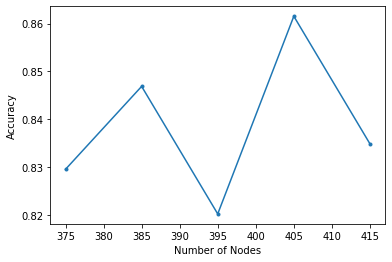

In [60]:
#Graph results
plt.plot(range(375, 425, 10), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [61]:
# It looks like best value is somewhere between 400 and 410
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(400, 410, 1):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 1:14 - loss: 17.2283 - accuracy: 0.406 - ETA: 5s - loss: 8.5130 - accuracy: 0.5260  - ETA: 2s - loss: 7.9764 - accuracy: 0.53 - ETA: 1s - loss: 7.3628 - accuracy: 0.55 - ETA: 0s - loss: 7.0756 - accuracy: 0.55 - ETA: 0s - loss: 6.9232 - accuracy: 0.54 - ETA: 0s - loss: 6.6278 - accuracy: 0.55 - 1s 637us/sample - loss: 6.5164 - accuracy: 0.5595
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.8271 - accuracy: 0.53 - ETA: 0s - loss: 4.6948 - accuracy: 0.60 - ETA: 0s - loss: 4.5429 - accuracy: 0.60 - ETA: 0s - loss: 4.6688 - accuracy: 0.59 - ETA: 0s - loss: 4.7905 - accuracy: 0.60 - ETA: 0s - loss: 4.8501 - accuracy: 0.60 - ETA: 0s - loss: 4.8223 - accuracy: 0.60 - 0s 161us/sample - loss: 4.7553 - accuracy: 0.6052
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 4.1386 - accuracy: 0.62 - ETA: 0s - loss: 3.6432 - accuracy: 0.61 - ETA: 0s - loss: 3.4970 - accura

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 51s - loss: 8.6772 - accuracy: 0.250 - ETA: 4s - loss: 6.6526 - accuracy: 0.540 - ETA: 2s - loss: 6.0008 - accuracy: 0.56 - ETA: 1s - loss: 5.9018 - accuracy: 0.56 - ETA: 0s - loss: 5.8022 - accuracy: 0.56 - ETA: 0s - loss: 5.7484 - accuracy: 0.56 - ETA: 0s - loss: 5.6615 - accuracy: 0.56 - ETA: 0s - loss: 5.5723 - accuracy: 0.56 - 1s 509us/sample - loss: 5.4377 - accuracy: 0.5706
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.3976 - accuracy: 0.59 - ETA: 0s - loss: 4.9528 - accuracy: 0.61 - ETA: 0s - loss: 4.6458 - accuracy: 0.63 - ETA: 0s - loss: 4.3180 - accuracy: 0.63 - ETA: 0s - loss: 4.1966 - accuracy: 0.63 - ETA: 0s - loss: 4.2739 - accuracy: 0.62 - ETA: 0s - loss: 4.1489 - accuracy: 0.62 - ETA: 0s - loss: 4.0088 - accuracy: 0.63 - 0s 183us/sample - loss: 3.9917 - accuracy: 0.6314
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.2821 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 46s - loss: 10.4048 - accuracy: 0.40 - ETA: 3s - loss: 7.8461 - accuracy: 0.5398 - ETA: 1s - loss: 7.2043 - accuracy: 0.54 - ETA: 1s - loss: 6.5367 - accuracy: 0.56 - ETA: 0s - loss: 6.4509 - accuracy: 0.56 - ETA: 0s - loss: 6.2704 - accuracy: 0.56 - ETA: 0s - loss: 6.0673 - accuracy: 0.57 - 1s 460us/sample - loss: 6.0982 - accuracy: 0.5710
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.6767 - accuracy: 0.59 - ETA: 0s - loss: 4.0610 - accuracy: 0.62 - ETA: 0s - loss: 3.9703 - accuracy: 0.61 - ETA: 0s - loss: 4.4926 - accuracy: 0.59 - ETA: 0s - loss: 4.5020 - accuracy: 0.58 - ETA: 0s - loss: 4.3955 - accuracy: 0.58 - ETA: 0s - loss: 4.3965 - accuracy: 0.58 - 0s 161us/sample - loss: 4.3092 - accuracy: 0.5910
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.75 - ETA: 0s - loss: 3.5382 - accuracy: 0.65 - ETA: 0s - loss: 3.5012 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 42s - loss: 15.0004 - accuracy: 0.40 - ETA: 3s - loss: 8.2397 - accuracy: 0.5142 - ETA: 1s - loss: 7.5415 - accuracy: 0.55 - ETA: 1s - loss: 7.2186 - accuracy: 0.56 - ETA: 0s - loss: 7.0829 - accuracy: 0.56 - ETA: 0s - loss: 7.0138 - accuracy: 0.55 - ETA: 0s - loss: 6.6917 - accuracy: 0.55 - ETA: 0s - loss: 6.4958 - accuracy: 0.55 - 1s 437us/sample - loss: 6.5024 - accuracy: 0.5560
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 6.2586 - accuracy: 0.65 - ETA: 0s - loss: 5.6791 - accuracy: 0.59 - ETA: 0s - loss: 5.1241 - accuracy: 0.60 - ETA: 0s - loss: 4.6077 - accuracy: 0.61 - ETA: 0s - loss: 4.4012 - accuracy: 0.60 - ETA: 0s - loss: 4.3775 - accuracy: 0.60 - ETA: 0s - loss: 4.1187 - accuracy: 0.61 - 0s 160us/sample - loss: 3.9960 - accuracy: 0.6261
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 5.4814 - accuracy: 0.59 - ETA: 0s - loss: 3.8166 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 39s - loss: 8.8175 - accuracy: 0.468 - ETA: 3s - loss: 6.8818 - accuracy: 0.573 - ETA: 1s - loss: 6.9884 - accuracy: 0.55 - ETA: 0s - loss: 6.8296 - accuracy: 0.55 - ETA: 0s - loss: 6.8140 - accuracy: 0.56 - ETA: 0s - loss: 6.8325 - accuracy: 0.55 - ETA: 0s - loss: 6.7510 - accuracy: 0.56 - 1s 413us/sample - loss: 6.4729 - accuracy: 0.5688
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 5.6015 - accuracy: 0.62 - ETA: 0s - loss: 5.9333 - accuracy: 0.56 - ETA: 0s - loss: 5.6970 - accuracy: 0.57 - ETA: 0s - loss: 5.4909 - accuracy: 0.60 - ETA: 0s - loss: 5.5173 - accuracy: 0.60 - ETA: 0s - loss: 5.1594 - accuracy: 0.61 - ETA: 0s - loss: 5.0795 - accuracy: 0.61 - 0s 160us/sample - loss: 5.0196 - accuracy: 0.6181
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 6.6179 - accuracy: 0.56 - ETA: 0s - loss: 5.0383 - accuracy: 0.58 - ETA: 0s - loss: 4.5854 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 47s - loss: 6.1790 - accuracy: 0.562 - ETA: 5s - loss: 6.4289 - accuracy: 0.562 - ETA: 2s - loss: 6.9516 - accuracy: 0.52 - ETA: 1s - loss: 6.7390 - accuracy: 0.53 - ETA: 0s - loss: 6.5300 - accuracy: 0.53 - ETA: 0s - loss: 6.4194 - accuracy: 0.55 - ETA: 0s - loss: 6.2678 - accuracy: 0.56 - 1s 469us/sample - loss: 6.0740 - accuracy: 0.5679
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.4934 - accuracy: 0.68 - ETA: 0s - loss: 4.3822 - accuracy: 0.61 - ETA: 0s - loss: 5.0362 - accuracy: 0.60 - ETA: 0s - loss: 5.0021 - accuracy: 0.61 - ETA: 0s - loss: 4.9585 - accuracy: 0.61 - ETA: 0s - loss: 4.7432 - accuracy: 0.62 - ETA: 0s - loss: 4.6728 - accuracy: 0.61 - 0s 159us/sample - loss: 4.5385 - accuracy: 0.6132
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 6.9638 - accuracy: 0.46 - ETA: 0s - loss: 3.7190 - accuracy: 0.62 - ETA: 0s - loss: 3.4587 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 51s - loss: 13.5574 - accuracy: 0.25 - ETA: 4s - loss: 7.4339 - accuracy: 0.5406 - ETA: 2s - loss: 7.4988 - accuracy: 0.54 - ETA: 1s - loss: 7.1873 - accuracy: 0.55 - ETA: 0s - loss: 6.6628 - accuracy: 0.55 - ETA: 0s - loss: 6.5932 - accuracy: 0.55 - ETA: 0s - loss: 6.4161 - accuracy: 0.56 - ETA: 0s - loss: 6.3445 - accuracy: 0.55 - 1s 502us/sample - loss: 6.4092 - accuracy: 0.5568
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 2.9643 - accuracy: 0.50 - ETA: 0s - loss: 5.7277 - accuracy: 0.54 - ETA: 0s - loss: 5.2257 - accuracy: 0.58 - ETA: 0s - loss: 4.7697 - accuracy: 0.59 - ETA: 0s - loss: 4.7415 - accuracy: 0.59 - ETA: 0s - loss: 4.6970 - accuracy: 0.59 - ETA: 0s - loss: 4.3565 - accuracy: 0.60 - ETA: 0s - loss: 4.2586 - accuracy: 0.60 - 0s 173us/sample - loss: 4.2488 - accuracy: 0.6101
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.6604 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 48s - loss: 7.9975 - accuracy: 0.656 - ETA: 4s - loss: 7.2760 - accuracy: 0.568 - ETA: 2s - loss: 6.9433 - accuracy: 0.56 - ETA: 1s - loss: 6.6964 - accuracy: 0.54 - ETA: 0s - loss: 6.7203 - accuracy: 0.54 - ETA: 0s - loss: 6.3722 - accuracy: 0.54 - ETA: 0s - loss: 5.9591 - accuracy: 0.56 - ETA: 0s - loss: 5.8648 - accuracy: 0.56 - 1s 486us/sample - loss: 5.7178 - accuracy: 0.5675
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.3772 - accuracy: 0.59 - ETA: 0s - loss: 5.3726 - accuracy: 0.56 - ETA: 0s - loss: 4.8185 - accuracy: 0.57 - ETA: 0s - loss: 4.8072 - accuracy: 0.57 - ETA: 0s - loss: 4.7186 - accuracy: 0.59 - ETA: 0s - loss: 4.5774 - accuracy: 0.59 - ETA: 0s - loss: 4.4562 - accuracy: 0.59 - ETA: 0s - loss: 4.4589 - accuracy: 0.60 - 0s 184us/sample - loss: 4.3829 - accuracy: 0.6012
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.2652 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 53s - loss: 13.5961 - accuracy: 0.28 - ETA: 4s - loss: 8.8983 - accuracy: 0.5085 - ETA: 2s - loss: 7.2801 - accuracy: 0.55 - ETA: 1s - loss: 6.5724 - accuracy: 0.56 - ETA: 0s - loss: 6.5806 - accuracy: 0.56 - ETA: 0s - loss: 6.5410 - accuracy: 0.56 - ETA: 0s - loss: 6.3176 - accuracy: 0.56 - 1s 510us/sample - loss: 6.1701 - accuracy: 0.5684
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.3609 - accuracy: 0.56 - ETA: 0s - loss: 4.9772 - accuracy: 0.61 - ETA: 0s - loss: 5.4972 - accuracy: 0.60 - ETA: 0s - loss: 5.2825 - accuracy: 0.59 - ETA: 0s - loss: 4.9909 - accuracy: 0.60 - ETA: 0s - loss: 4.7555 - accuracy: 0.61 - ETA: 0s - loss: 4.7414 - accuracy: 0.61 - 0s 167us/sample - loss: 4.7604 - accuracy: 0.6061
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.1333 - accuracy: 0.65 - ETA: 0s - loss: 3.6566 - accuracy: 0.62 - ETA: 0s - loss: 3.8199 - accuracy:

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 2252 samples
Epoch 1/10
2252/2252 [==============================] - ETA: 50s - loss: 8.9510 - accuracy: 0.375 - ETA: 4s - loss: 6.1966 - accuracy: 0.559 - ETA: 2s - loss: 6.7711 - accuracy: 0.56 - ETA: 1s - loss: 6.5311 - accuracy: 0.55 - ETA: 0s - loss: 6.2560 - accuracy: 0.56 - ETA: 0s - loss: 6.5508 - accuracy: 0.55 - ETA: 0s - loss: 6.4914 - accuracy: 0.55 - ETA: 0s - loss: 6.4137 - accuracy: 0.55 - 1s 497us/sample - loss: 6.3611 - accuracy: 0.5608
Epoch 2/10
2252/2252 [==============================] - ETA: 0s - loss: 4.1874 - accuracy: 0.68 - ETA: 0s - loss: 4.8681 - accuracy: 0.57 - ETA: 0s - loss: 5.2365 - accuracy: 0.58 - ETA: 0s - loss: 4.9290 - accuracy: 0.59 - ETA: 0s - loss: 4.8597 - accuracy: 0.60 - ETA: 0s - loss: 4.8325 - accuracy: 0.59 - ETA: 0s - loss: 4.7957 - accuracy: 0.60 - 0s 165us/sample - loss: 4.7127 - accuracy: 0.6066
Epoch 3/10
2252/2252 [==============================] - ETA: 0s - loss: 3.3384 - accuracy: 0.62 - ETA: 0s - loss: 4.0852 - accuracy: 

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Accuracy')

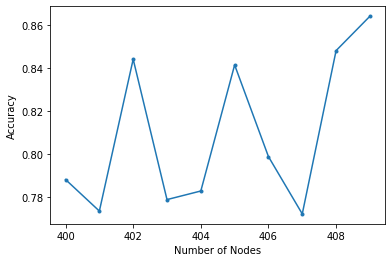

In [62]:
#Graph results
plt.plot(range(400, 410, 1), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [63]:
#Best value is 400. Re-run model with this value and 50 epochs, since we have tuned all the parameters.
build_model_output = build_model(400, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

Train on 2252 samples
Epoch 1/50
2252/2252 [==============================] - ETA: 50s - loss: 24.7090 - accuracy: 0.37 - ETA: 4s - loss: 13.9746 - accuracy: 0.5063 - ETA: 2s - loss: 11.5761 - accuracy: 0.536 - ETA: 1s - loss: 9.8019 - accuracy: 0.548 - ETA: 0s - loss: 8.7892 - accuracy: 0.55 - ETA: 0s - loss: 8.2169 - accuracy: 0.56 - ETA: 0s - loss: 8.0275 - accuracy: 0.55 - ETA: 0s - loss: 7.6118 - accuracy: 0.55 - 1s 503us/sample - loss: 7.5215 - accuracy: 0.5573
Epoch 2/50
2252/2252 [==============================] - ETA: 0s - loss: 5.5068 - accuracy: 0.50 - ETA: 0s - loss: 5.8038 - accuracy: 0.58 - ETA: 0s - loss: 5.6357 - accuracy: 0.56 - ETA: 0s - loss: 5.4225 - accuracy: 0.57 - ETA: 0s - loss: 5.1320 - accuracy: 0.58 - ETA: 0s - loss: 5.0050 - accuracy: 0.59 - ETA: 0s - loss: 4.8131 - accuracy: 0.59 - ETA: 0s - loss: 4.6090 - accuracy: 0.60 - 0s 172us/sample - loss: 4.6184 - accuracy: 0.6057
Epoch 3/50
2252/2252 [==============================] - ETA: 0s - loss: 1.9646 - accur

2252/2252 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.84 - ETA: 0s - loss: 0.3870 - accuracy: 0.82 - ETA: 0s - loss: 0.4140 - accuracy: 0.81 - ETA: 0s - loss: 0.3901 - accuracy: 0.82 - ETA: 0s - loss: 0.4002 - accuracy: 0.81 - ETA: 0s - loss: 0.4090 - accuracy: 0.80 - ETA: 0s - loss: 0.4075 - accuracy: 0.80 - ETA: 0s - loss: 0.3977 - accuracy: 0.81 - 0s 182us/sample - loss: 0.4027 - accuracy: 0.8095
Epoch 20/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.81 - ETA: 0s - loss: 0.3851 - accuracy: 0.83 - ETA: 0s - loss: 0.3734 - accuracy: 0.84 - ETA: 0s - loss: 0.3829 - accuracy: 0.83 - ETA: 0s - loss: 0.3964 - accuracy: 0.82 - ETA: 0s - loss: 0.3874 - accuracy: 0.83 - ETA: 0s - loss: 0.3901 - accuracy: 0.82 - ETA: 0s - loss: 0.3873 - accuracy: 0.82 - 0s 184us/sample - loss: 0.3880 - accuracy: 0.8228
Epoch 21/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.81 - ETA: 0s - loss: 0.4103 - ac

2252/2252 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.84 - ETA: 0s - loss: 0.4135 - accuracy: 0.80 - ETA: 0s - loss: 0.3751 - accuracy: 0.82 - ETA: 0s - loss: 0.3695 - accuracy: 0.83 - ETA: 0s - loss: 0.3770 - accuracy: 0.82 - ETA: 0s - loss: 0.3789 - accuracy: 0.82 - ETA: 0s - loss: 0.3863 - accuracy: 0.82 - ETA: 0s - loss: 0.3838 - accuracy: 0.83 - ETA: 0s - loss: 0.3851 - accuracy: 0.82 - 0s 203us/sample - loss: 0.3829 - accuracy: 0.8264
Epoch 37/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.81 - ETA: 0s - loss: 0.4897 - accuracy: 0.78 - ETA: 0s - loss: 0.4800 - accuracy: 0.78 - ETA: 0s - loss: 0.4332 - accuracy: 0.80 - ETA: 0s - loss: 0.4045 - accuracy: 0.81 - ETA: 0s - loss: 0.3963 - accuracy: 0.82 - ETA: 0s - loss: 0.3865 - accuracy: 0.82 - ETA: 0s - loss: 0.3888 - accuracy: 0.82 - 0s 190us/sample - loss: 0.3919 - accuracy: 0.8228
Epoch 38/50
2252/2252 [==============================] - ETA: 0s - loss: 0.2089 - ac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.8708389


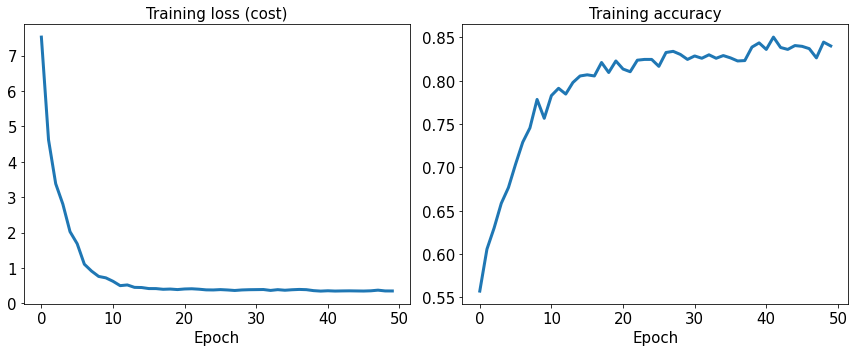

In [64]:
# Plot training cost and accuracy
hist = fit_model_output.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

In [65]:
# Run final model against test data
build_model_output = build_model(400, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, test_data9, test_labels9)
print(final_accuracy)

Train on 2252 samples
Epoch 1/50
2252/2252 [==============================] - ETA: 40s - loss: 12.6521 - accuracy: 0.34 - ETA: 3s - loss: 8.4715 - accuracy: 0.5104 - ETA: 1s - loss: 8.1510 - accuracy: 0.52 - ETA: 0s - loss: 7.3845 - accuracy: 0.54 - ETA: 0s - loss: 7.0698 - accuracy: 0.54 - ETA: 0s - loss: 6.9176 - accuracy: 0.54 - ETA: 0s - loss: 6.6988 - accuracy: 0.55 - 1s 411us/sample - loss: 6.4792 - accuracy: 0.5666
Epoch 2/50
2252/2252 [==============================] - ETA: 0s - loss: 2.1671 - accuracy: 0.71 - ETA: 0s - loss: 4.9908 - accuracy: 0.59 - ETA: 0s - loss: 5.2548 - accuracy: 0.59 - ETA: 0s - loss: 5.0992 - accuracy: 0.59 - ETA: 0s - loss: 5.0159 - accuracy: 0.60 - ETA: 0s - loss: 4.9010 - accuracy: 0.59 - ETA: 0s - loss: 4.6859 - accuracy: 0.60 - 0s 151us/sample - loss: 4.6071 - accuracy: 0.6106
Epoch 3/50
2252/2252 [==============================] - ETA: 0s - loss: 5.3369 - accuracy: 0.59 - ETA: 0s - loss: 4.0632 - accuracy: 0.62 - ETA: 0s - loss: 3.4957 - accuracy:

2252/2252 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.87 - ETA: 0s - loss: 0.4169 - accuracy: 0.80 - ETA: 0s - loss: 0.4096 - accuracy: 0.80 - ETA: 0s - loss: 0.4099 - accuracy: 0.81 - ETA: 0s - loss: 0.3954 - accuracy: 0.81 - ETA: 0s - loss: 0.3937 - accuracy: 0.81 - ETA: 0s - loss: 0.3928 - accuracy: 0.82 - ETA: 0s - loss: 0.3988 - accuracy: 0.81 - 0s 190us/sample - loss: 0.4046 - accuracy: 0.8131
Epoch 21/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.84 - ETA: 0s - loss: 0.4331 - accuracy: 0.78 - ETA: 0s - loss: 0.4803 - accuracy: 0.79 - ETA: 0s - loss: 0.4499 - accuracy: 0.80 - ETA: 0s - loss: 0.4498 - accuracy: 0.79 - ETA: 0s - loss: 0.4305 - accuracy: 0.80 - ETA: 0s - loss: 0.4313 - accuracy: 0.80 - ETA: 0s - loss: 0.4249 - accuracy: 0.80 - 0s 179us/sample - loss: 0.4222 - accuracy: 0.8108
Epoch 22/50
2252/2252 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.87 - ETA: 0s - loss: 0.3514 - ac

2252/2252 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.96 - ETA: 0s - loss: 0.4235 - accuracy: 0.82 - ETA: 0s - loss: 0.4168 - accuracy: 0.82 - ETA: 0s - loss: 0.4085 - accuracy: 0.82 - ETA: 0s - loss: 0.4068 - accuracy: 0.81 - ETA: 0s - loss: 0.4003 - accuracy: 0.81 - ETA: 0s - loss: 0.3929 - accuracy: 0.82 - ETA: 0s - loss: 0.3923 - accuracy: 0.82 - 0s 182us/sample - loss: 0.3887 - accuracy: 0.8273
Epoch 39/50
2252/2252 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.84 - ETA: 0s - loss: 0.3580 - accuracy: 0.84 - ETA: 0s - loss: 0.3571 - accuracy: 0.83 - ETA: 0s - loss: 0.3598 - accuracy: 0.83 - ETA: 0s - loss: 0.3534 - accuracy: 0.84 - ETA: 0s - loss: 0.3590 - accuracy: 0.83 - ETA: 0s - loss: 0.3609 - accuracy: 0.83 - ETA: 0s - loss: 0.3583 - accuracy: 0.83 - 0s 185us/sample - loss: 0.3609 - accuracy: 0.8339
Epoch 40/50
2252/2252 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.75 - ETA: 0s - loss: 0.3488 - ac

751/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.8335553


**Conclusions**